# Day 7: Market Microstructure Interview Questions

## Week 21 - Market Microstructure

This notebook covers **10 essential market microstructure interview questions** commonly asked in quant trading interviews. Each question includes:
- Theoretical explanation
- Python implementation
- Key insights for interviews

### Topics Covered:
1. Bid-Ask Spread Calculation
2. VWAP (Volume Weighted Average Price)
3. TWAP (Time Weighted Average Price)
4. Order Book Imbalance
5. Kyle's Lambda (Price Impact)
6. Roll's Spread Estimator
7. Realized Volatility from Tick Data
8. Trade Classification (Lee-Ready Algorithm)
9. Amihud Illiquidity Measure
10. Effective Spread Calculation

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.float_format', '{:.6f}'.format)
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 2.4.1
Pandas version: 2.3.3


---

## Question 1: Bid-Ask Spread Calculation

### Interview Question:
*"Explain what the bid-ask spread is and calculate quoted spread, percentage spread, and mid-price from the following data. Why do spreads matter for trading costs?"*

### Key Concepts:
- **Bid Price**: Highest price a buyer is willing to pay
- **Ask Price**: Lowest price a seller is willing to accept
- **Quoted Spread**: Ask - Bid (absolute spread)
- **Percentage Spread**: (Ask - Bid) / Mid-Price × 100
- **Mid-Price**: (Bid + Ask) / 2

### Why Spreads Matter:
1. **Direct Trading Cost**: Crossing the spread is an immediate transaction cost
2. **Liquidity Indicator**: Narrow spreads = high liquidity
3. **Market Maker Compensation**: Spread compensates for adverse selection risk
4. **Strategy Viability**: HFT strategies need tight spreads to be profitable

In [2]:
# Question 1: Bid-Ask Spread Calculation

def calculate_spread_metrics(bid: float, ask: float) -> dict:
    """
    Calculate various spread metrics from bid and ask prices.
    
    Parameters:
    -----------
    bid : float - Bid price (highest buy order)
    ask : float - Ask price (lowest sell order)
    
    Returns:
    --------
    dict : Dictionary containing all spread metrics
    """
    mid_price = (bid + ask) / 2
    quoted_spread = ask - bid
    percentage_spread = (quoted_spread / mid_price) * 100
    half_spread = quoted_spread / 2
    
    return {
        'bid': bid,
        'ask': ask,
        'mid_price': mid_price,
        'quoted_spread': quoted_spread,
        'percentage_spread': percentage_spread,
        'half_spread': half_spread,
        'spread_bps': percentage_spread * 100  # Basis points
    }

# Example: AAPL quote data
bid_price = 185.50
ask_price = 185.55

metrics = calculate_spread_metrics(bid_price, ask_price)

print("=" * 50)
print("BID-ASK SPREAD ANALYSIS")
print("=" * 50)
for key, value in metrics.items():
    if key == 'percentage_spread':
        print(f"{key:20}: {value:.4f}%")
    elif key == 'spread_bps':
        print(f"{key:20}: {value:.2f} bps")
    else:
        print(f"{key:20}: ${value:.4f}" if 'spread' in key or 'price' in key or key in ['bid', 'ask'] 
              else f"{key:20}: {value:.4f}")

# Simulate multiple quotes throughout the day
print("\n" + "=" * 50)
print("SPREAD ANALYSIS OVER TIME")
print("=" * 50)

times = pd.date_range('2024-01-15 09:30', periods=10, freq='30min')
bids = 185.50 + np.random.randn(10) * 0.10
asks = bids + np.abs(np.random.randn(10) * 0.05) + 0.01  # Ensure ask > bid

quote_df = pd.DataFrame({
    'time': times,
    'bid': bids,
    'ask': asks
})

quote_df['mid_price'] = (quote_df['bid'] + quote_df['ask']) / 2
quote_df['quoted_spread'] = quote_df['ask'] - quote_df['bid']
quote_df['spread_bps'] = (quote_df['quoted_spread'] / quote_df['mid_price']) * 10000

print(quote_df.to_string(index=False))
print(f"\nAverage Spread: {quote_df['spread_bps'].mean():.2f} bps")
print(f"Spread Std Dev: {quote_df['spread_bps'].std():.2f} bps")

BID-ASK SPREAD ANALYSIS
bid                 : $185.5000
ask                 : $185.5500
mid_price           : $185.5250
quoted_spread       : $0.0500
percentage_spread   : 0.0270%
half_spread         : $0.0250
spread_bps          : 2.70 bps

SPREAD ANALYSIS OVER TIME
               time        bid        ask  mid_price  quoted_spread  spread_bps
2024-01-15 09:30:00 185.549671 185.582842 185.566257       0.033171    1.787549
2024-01-15 10:00:00 185.486174 185.519460 185.502817       0.033286    1.794393
2024-01-15 10:30:00 185.564769 185.586867 185.575818       0.022098    1.190786
2024-01-15 11:00:00 185.652303 185.757967 185.705135       0.105664    5.689881
2024-01-15 11:30:00 185.476585 185.572831 185.524708       0.096246    5.187767
2024-01-15 12:00:00 185.476586 185.514701 185.495643       0.038114    2.054732
2024-01-15 12:30:00 185.657921 185.718563 185.688242       0.060642    3.265773
2024-01-15 13:00:00 185.576743 185.602456 185.589600       0.025712    1.385442
2024-01-15 1

---

## Question 2: Calculate VWAP (Volume Weighted Average Price)

### Interview Question:
*"Implement VWAP calculation from trade data. Explain its use as an execution benchmark and how traders use it to minimize market impact."*

### Key Concepts:
- **VWAP Formula**: $VWAP = \frac{\sum_{i} (Price_i \times Volume_i)}{\sum_{i} Volume_i}$
- **Usage**: Benchmark for institutional execution quality
- **Interpretation**: Average price weighted by trading activity

### Why VWAP Matters:
1. **Execution Benchmark**: Institutions compare their execution price to VWAP
2. **Market Impact Minimization**: Trading at VWAP means trading with the market
3. **Fair Value Estimate**: Reflects "fair" average price during the day
4. **Order Slicing**: VWAP algorithms slice orders to match historical volume profiles

VWAP CALCULATION
Total Trades: 100
Total Volume: 151,158
Simple Average Price: $100.2577
VWAP: $100.2834
Difference: $0.0257


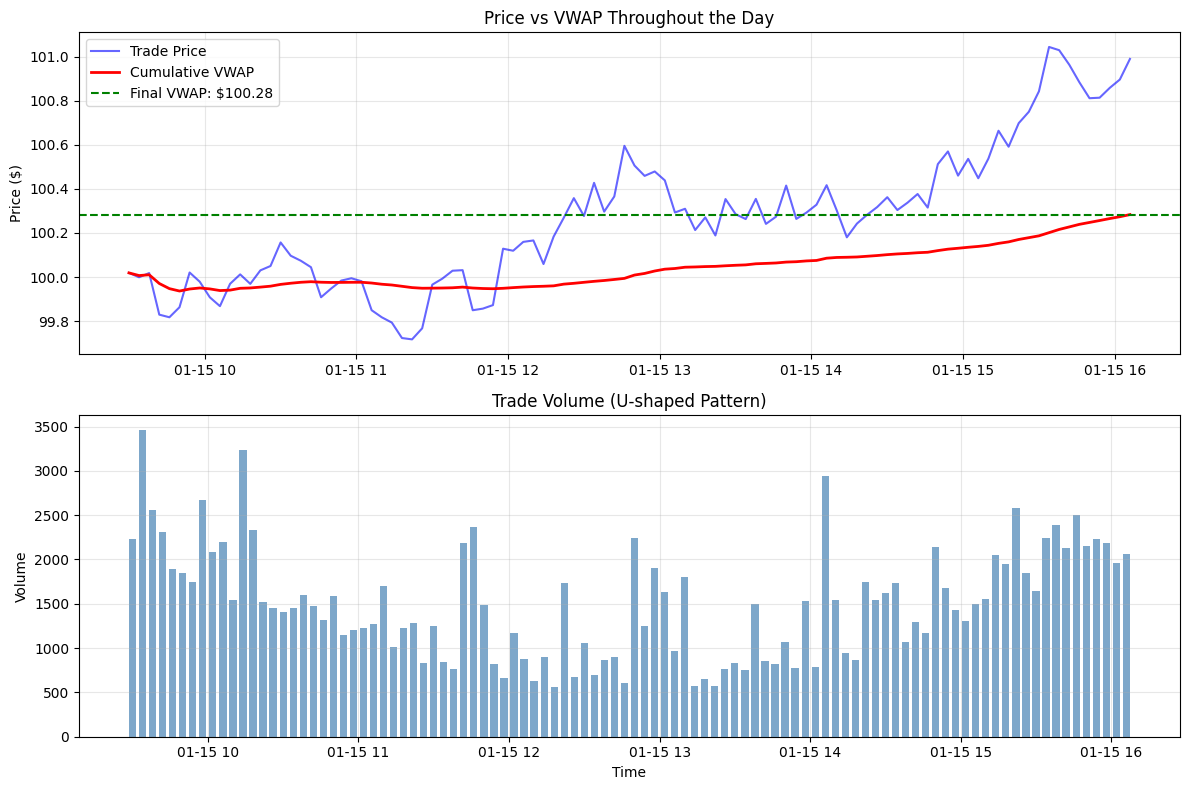


EXECUTION QUALITY ASSESSMENT
Trade 1: Price=$100.15, Volume=5,000, Slippage vs VWAP: -13.30 bps ($-666.82)
Trade 2: Price=$100.08, Volume=3,000, Slippage vs VWAP: -20.28 bps ($-610.09)
Trade 3: Price=$99.95, Volume=4,000, Slippage vs VWAP: -33.24 bps ($-1333.46)
Trade 4: Price=$100.22, Volume=2,000, Slippage vs VWAP: -6.32 bps ($-126.73)


In [3]:
# Question 2: VWAP Calculation

def calculate_vwap(prices: np.ndarray, volumes: np.ndarray) -> float:
    """
    Calculate Volume Weighted Average Price.
    
    VWAP = Σ(Price × Volume) / Σ(Volume)
    
    Parameters:
    -----------
    prices : array - Trade prices
    volumes : array - Trade volumes
    
    Returns:
    --------
    float : VWAP value
    """
    return np.sum(prices * volumes) / np.sum(volumes)


def calculate_rolling_vwap(df: pd.DataFrame, price_col: str, volume_col: str) -> pd.Series:
    """Calculate cumulative VWAP throughout the day."""
    cumulative_pv = (df[price_col] * df[volume_col]).cumsum()
    cumulative_volume = df[volume_col].cumsum()
    return cumulative_pv / cumulative_volume


# Generate synthetic trade data for a trading day
np.random.seed(42)
n_trades = 100

# Simulate U-shaped volume pattern (high at open/close)
time_of_day = np.linspace(0, 1, n_trades)
volume_pattern = 2 - 1.5 * np.sin(np.pi * time_of_day)  # U-shape
volumes = (volume_pattern * 1000 + np.random.exponential(500, n_trades)).astype(int)

# Simulate price with slight upward drift and volatility
base_price = 100
price_returns = np.random.randn(n_trades) * 0.001 + 0.0001  # Slight upward drift
prices = base_price * np.cumprod(1 + price_returns)

# Create trade DataFrame
trade_times = pd.date_range('2024-01-15 09:30', periods=n_trades, freq='4min')
trades_df = pd.DataFrame({
    'time': trade_times,
    'price': prices,
    'volume': volumes
})

# Calculate VWAP
vwap = calculate_vwap(trades_df['price'].values, trades_df['volume'].values)
trades_df['cumulative_vwap'] = calculate_rolling_vwap(trades_df, 'price', 'volume')

print("=" * 50)
print("VWAP CALCULATION")
print("=" * 50)
print(f"Total Trades: {n_trades}")
print(f"Total Volume: {trades_df['volume'].sum():,}")
print(f"Simple Average Price: ${trades_df['price'].mean():.4f}")
print(f"VWAP: ${vwap:.4f}")
print(f"Difference: ${vwap - trades_df['price'].mean():.4f}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Price and VWAP
axes[0].plot(trades_df['time'], trades_df['price'], 'b-', alpha=0.6, label='Trade Price')
axes[0].plot(trades_df['time'], trades_df['cumulative_vwap'], 'r-', linewidth=2, label='Cumulative VWAP')
axes[0].axhline(y=vwap, color='g', linestyle='--', label=f'Final VWAP: ${vwap:.2f}')
axes[0].set_ylabel('Price ($)')
axes[0].set_title('Price vs VWAP Throughout the Day')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Volume bars
axes[1].bar(trades_df['time'], trades_df['volume'], width=0.002, alpha=0.7, color='steelblue')
axes[1].set_ylabel('Volume')
axes[1].set_xlabel('Time')
axes[1].set_title('Trade Volume (U-shaped Pattern)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Execution quality example
print("\n" + "=" * 50)
print("EXECUTION QUALITY ASSESSMENT")
print("=" * 50)
execution_prices = [100.15, 100.08, 99.95, 100.22]
execution_volumes = [5000, 3000, 4000, 2000]

for i, (price, vol) in enumerate(zip(execution_prices, execution_volumes)):
    slippage = (price - vwap) * vol
    slippage_bps = ((price / vwap) - 1) * 10000
    print(f"Trade {i+1}: Price=${price:.2f}, Volume={vol:,}, Slippage vs VWAP: {slippage_bps:.2f} bps (${slippage:.2f})")

---

## Question 3: Implement TWAP (Time Weighted Average Price)

### Interview Question:
*"Calculate TWAP and compare it with VWAP. When is TWAP preferred over VWAP for order execution?"*

### Key Concepts:
- **TWAP Formula**: $TWAP = \frac{1}{N} \sum_{i=1}^{N} Price_i$ (simple average over equal time intervals)
- **Execution Strategy**: Divide order equally across time intervals
- **Key Difference**: TWAP ignores volume; VWAP weights by volume

### When to Use TWAP vs VWAP:
| Scenario | Preferred | Reason |
|----------|-----------|--------|
| Normal liquidity | VWAP | Trades with market flow |
| Low liquidity / illiquid stocks | TWAP | Volume profile unreliable |
| Avoiding gaming | TWAP | Less predictable pattern |
| Market close execution | VWAP | Capture closing volume spike |
| News-driven volatility | TWAP | Consistent execution pace |

TWAP vs VWAP COMPARISON
TWAP: $50.1307
VWAP: $50.1363
Difference (VWAP - TWAP): $0.0056
Difference in bps: 1.11 bps

EXECUTION COMPARISON

TWAP Execution:
  Average Execution Price: $50.1307
  Total Cost: $501,307.21

VWAP Execution:
  Average Execution Price: $50.1361
  Total Cost: $501,360.88

Cost Difference (VWAP - TWAP): $53.67


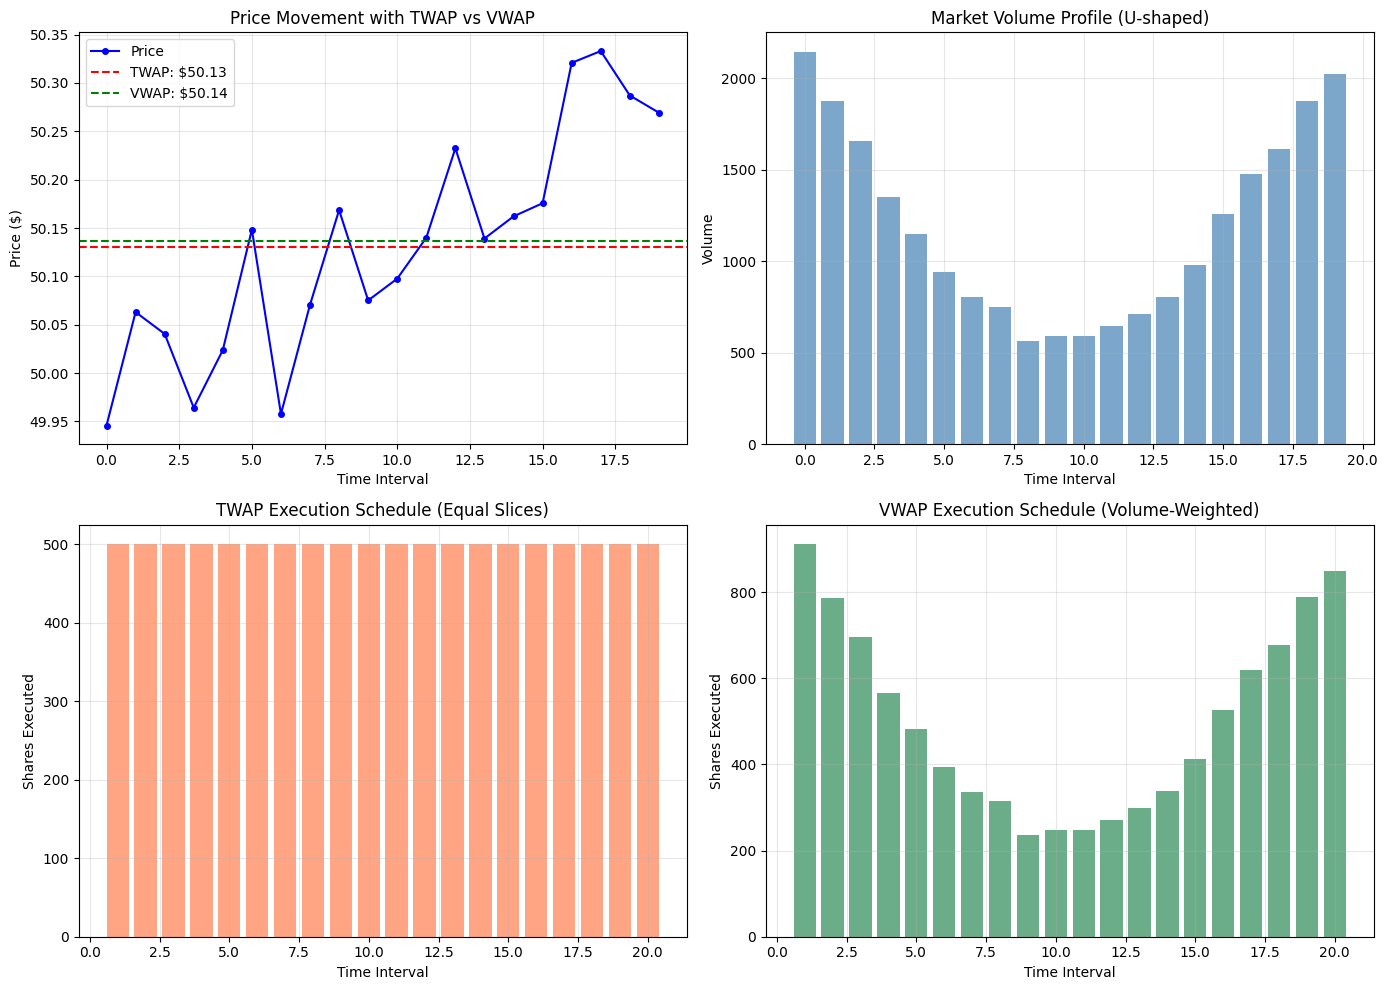

In [4]:
# Question 3: TWAP Calculation and Comparison

def calculate_twap(prices: np.ndarray) -> float:
    """
    Calculate Time Weighted Average Price.
    
    TWAP = (1/N) × Σ Price_i
    
    Simple arithmetic mean of prices sampled at equal time intervals.
    """
    return np.mean(prices)


def twap_execution_schedule(total_shares: int, n_intervals: int, 
                            prices: np.ndarray) -> pd.DataFrame:
    """
    Simulate TWAP execution: equal shares at each time interval.
    """
    shares_per_interval = total_shares // n_intervals
    remaining = total_shares % n_intervals
    
    # Distribute shares (add remainder to last trades)
    shares = np.full(n_intervals, shares_per_interval)
    shares[-remaining:] += 1 if remaining > 0 else 0
    
    execution_prices = prices[:n_intervals]
    
    df = pd.DataFrame({
        'interval': range(1, n_intervals + 1),
        'shares': shares,
        'price': execution_prices,
        'cost': shares * execution_prices
    })
    
    return df


def vwap_execution_schedule(total_shares: int, volume_profile: np.ndarray,
                            prices: np.ndarray) -> pd.DataFrame:
    """
    Simulate VWAP execution: shares proportional to volume profile.
    """
    # Normalize volume profile to get participation weights
    weights = volume_profile / volume_profile.sum()
    shares = (weights * total_shares).astype(int)
    
    # Adjust for rounding
    diff = total_shares - shares.sum()
    shares[np.argmax(weights)] += diff
    
    df = pd.DataFrame({
        'interval': range(1, len(shares) + 1),
        'shares': shares,
        'price': prices[:len(shares)],
        'cost': shares * prices[:len(shares)],
        'volume_weight': weights
    })
    
    return df


# Generate intraday price data with trend
np.random.seed(123)
n_intervals = 20
base_price = 50.0

# Price with upward trend (to show TWAP vs VWAP difference)
trend = np.linspace(0, 1, n_intervals) * 0.5  # 0.5% upward trend
noise = np.random.randn(n_intervals) * 0.1
prices = base_price * (1 + trend / 100 + noise / 100)

# U-shaped volume profile
time_normalized = np.linspace(0, 1, n_intervals)
volume_profile = 1000 * (2 - 1.5 * np.sin(np.pi * time_normalized)) + np.random.rand(n_intervals) * 200

# Calculate benchmarks
twap = calculate_twap(prices)
vwap = calculate_vwap(prices, volume_profile)

print("=" * 60)
print("TWAP vs VWAP COMPARISON")
print("=" * 60)
print(f"TWAP: ${twap:.4f}")
print(f"VWAP: ${vwap:.4f}")
print(f"Difference (VWAP - TWAP): ${vwap - twap:.4f}")
print(f"Difference in bps: {((vwap/twap) - 1) * 10000:.2f} bps")

# Simulate execution
total_order = 10000  # shares to execute

twap_exec = twap_execution_schedule(total_order, n_intervals, prices)
vwap_exec = vwap_execution_schedule(total_order, volume_profile, prices)

print("\n" + "=" * 60)
print("EXECUTION COMPARISON")
print("=" * 60)
print(f"\nTWAP Execution:")
print(f"  Average Execution Price: ${twap_exec['cost'].sum() / twap_exec['shares'].sum():.4f}")
print(f"  Total Cost: ${twap_exec['cost'].sum():,.2f}")

print(f"\nVWAP Execution:")
print(f"  Average Execution Price: ${vwap_exec['cost'].sum() / vwap_exec['shares'].sum():.4f}")
print(f"  Total Cost: ${vwap_exec['cost'].sum():,.2f}")

cost_diff = vwap_exec['cost'].sum() - twap_exec['cost'].sum()
print(f"\nCost Difference (VWAP - TWAP): ${cost_diff:,.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price with benchmarks
axes[0, 0].plot(range(n_intervals), prices, 'b-o', label='Price', markersize=4)
axes[0, 0].axhline(y=twap, color='r', linestyle='--', label=f'TWAP: ${twap:.2f}')
axes[0, 0].axhline(y=vwap, color='g', linestyle='--', label=f'VWAP: ${vwap:.2f}')
axes[0, 0].set_xlabel('Time Interval')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].set_title('Price Movement with TWAP vs VWAP')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Volume profile
axes[0, 1].bar(range(n_intervals), volume_profile, color='steelblue', alpha=0.7)
axes[0, 1].set_xlabel('Time Interval')
axes[0, 1].set_ylabel('Volume')
axes[0, 1].set_title('Market Volume Profile (U-shaped)')
axes[0, 1].grid(True, alpha=0.3)

# TWAP execution
axes[1, 0].bar(twap_exec['interval'], twap_exec['shares'], color='coral', alpha=0.7)
axes[1, 0].set_xlabel('Time Interval')
axes[1, 0].set_ylabel('Shares Executed')
axes[1, 0].set_title('TWAP Execution Schedule (Equal Slices)')
axes[1, 0].grid(True, alpha=0.3)

# VWAP execution
axes[1, 1].bar(vwap_exec['interval'], vwap_exec['shares'], color='seagreen', alpha=0.7)
axes[1, 1].set_xlabel('Time Interval')
axes[1, 1].set_ylabel('Shares Executed')
axes[1, 1].set_title('VWAP Execution Schedule (Volume-Weighted)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Question 4: Order Book Imbalance

### Interview Question:
*"Calculate order book imbalance from limit order book snapshots. How does imbalance predict short-term price movements?"*

### Key Concepts:
- **Order Book**: All outstanding limit orders at various price levels
- **Imbalance Formula**: $OBI = \frac{V_{bid} - V_{ask}}{V_{bid} + V_{ask}}$
- **Range**: [-1, +1], where +1 = all bids, -1 = all asks

### Predictive Power:
1. **Positive imbalance** → More buying pressure → Price likely to rise
2. **Negative imbalance** → More selling pressure → Price likely to fall
3. **Used in HFT** for short-term alpha signals (milliseconds to seconds)
4. **Volume at best levels** is most predictive (closest to execution)

ORDER BOOK SNAPSHOT

📕 BID SIDE (Buy Orders):
----------------------------------------
  $99.95  |    500  |  █████
  $99.90  |    800  |  ████████
  $99.85  |   1200  |  ████████████
  $99.80  |    600  |  ██████
  $99.75  |    400  |  ████

────────────────────────────────────────
  MID PRICE: $100.00
────────────────────────────────────────

📗 ASK SIDE (Sell Orders):
----------------------------------------
  $100.05  |    300  |  ███
  $100.10  |    600  |  ██████
  $100.15  |    900  |  █████████
  $100.20  |    500  |  █████
  $100.25  |    700  |  ███████

ORDER BOOK IMBALANCE METRICS
Best Level OBI (top of book): +0.2500
Total Book OBI:               +0.0769
Weighted OBI (decay=0.5):     +0.0812

📊 INTERPRETATION:
  → Buying pressure at best levels (OBI=+0.25)
  → Short-term price likely to RISE

OBI PREDICTIVE ANALYSIS
Correlation(OBI_t, Return_{t+1}): 0.6721


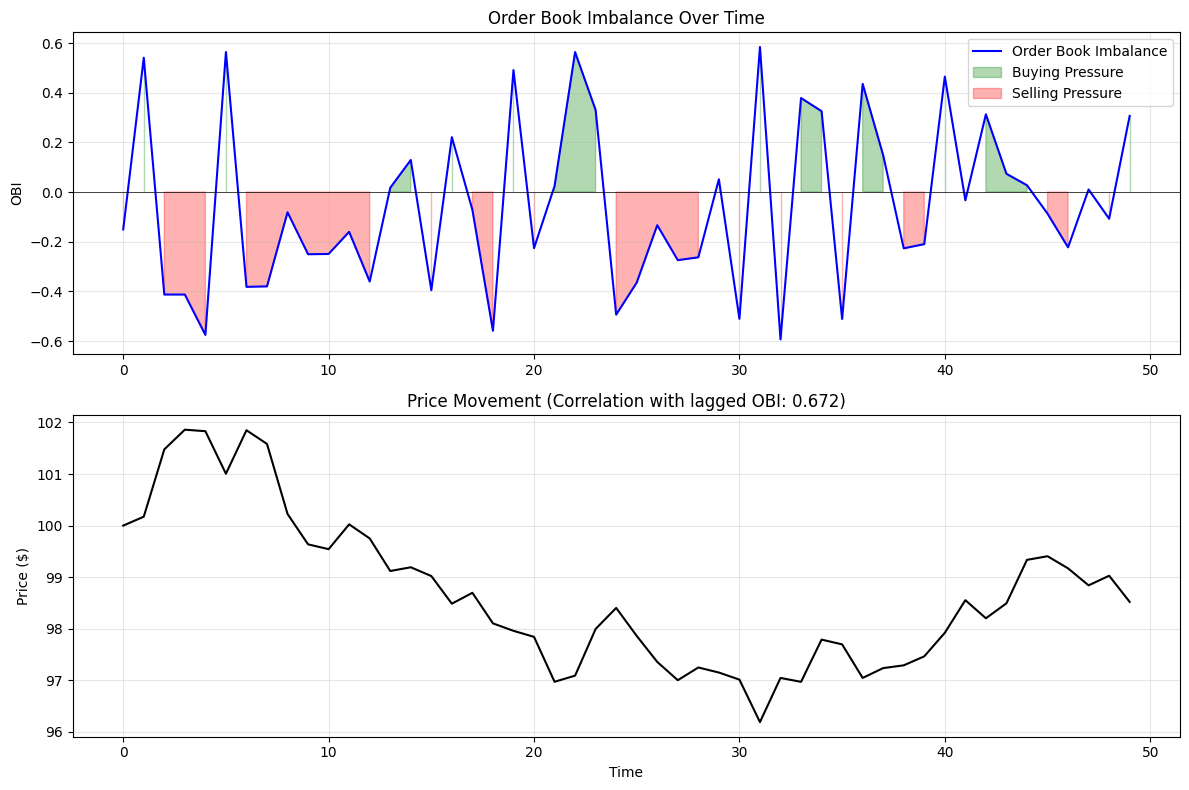

In [5]:
# Question 4: Order Book Imbalance

def calculate_order_book_imbalance(bid_volume: float, ask_volume: float) -> float:
    """
    Calculate Order Book Imbalance (OBI).
    
    OBI = (V_bid - V_ask) / (V_bid + V_ask)
    
    Returns value in [-1, 1]:
      +1: All volume is on bid side (strong buying pressure)
      -1: All volume is on ask side (strong selling pressure)
       0: Equal volume on both sides (balanced)
    """
    total_volume = bid_volume + ask_volume
    if total_volume == 0:
        return 0.0
    return (bid_volume - ask_volume) / total_volume


def weighted_order_book_imbalance(bid_prices: np.ndarray, bid_volumes: np.ndarray,
                                   ask_prices: np.ndarray, ask_volumes: np.ndarray,
                                   mid_price: float, decay: float = 0.5) -> float:
    """
    Calculate weighted OBI with price-distance decay.
    Orders closer to mid-price get higher weight.
    """
    # Distance from mid-price
    bid_distances = mid_price - bid_prices
    ask_distances = ask_prices - mid_price
    
    # Exponential decay weights
    bid_weights = np.exp(-decay * bid_distances)
    ask_weights = np.exp(-decay * ask_distances)
    
    weighted_bid = np.sum(bid_volumes * bid_weights)
    weighted_ask = np.sum(ask_volumes * ask_weights)
    
    return (weighted_bid - weighted_ask) / (weighted_bid + weighted_ask)


# Simulate limit order book
np.random.seed(42)

# Bid side (descending prices)
mid_price = 100.0
bid_prices = np.array([99.95, 99.90, 99.85, 99.80, 99.75])
bid_volumes = np.array([500, 800, 1200, 600, 400])

# Ask side (ascending prices)
ask_prices = np.array([100.05, 100.10, 100.15, 100.20, 100.25])
ask_volumes = np.array([300, 600, 900, 500, 700])

# Calculate imbalances
best_bid_vol = bid_volumes[0]
best_ask_vol = ask_volumes[0]
total_bid_vol = bid_volumes.sum()
total_ask_vol = ask_volumes.sum()

obi_best = calculate_order_book_imbalance(best_bid_vol, best_ask_vol)
obi_total = calculate_order_book_imbalance(total_bid_vol, total_ask_vol)
obi_weighted = weighted_order_book_imbalance(bid_prices, bid_volumes, 
                                              ask_prices, ask_volumes, mid_price)

print("=" * 60)
print("ORDER BOOK SNAPSHOT")
print("=" * 60)
print("\n📕 BID SIDE (Buy Orders):")
print("-" * 40)
for price, vol in zip(bid_prices, bid_volumes):
    bar = "█" * int(vol / 100)
    print(f"  ${price:.2f}  |  {vol:>5}  |  {bar}")

print(f"\n{'─' * 40}")
print(f"  MID PRICE: ${mid_price:.2f}")
print(f"{'─' * 40}")

print("\n📗 ASK SIDE (Sell Orders):")
print("-" * 40)
for price, vol in zip(ask_prices, ask_volumes):
    bar = "█" * int(vol / 100)
    print(f"  ${price:.2f}  |  {vol:>5}  |  {bar}")

print("\n" + "=" * 60)
print("ORDER BOOK IMBALANCE METRICS")
print("=" * 60)
print(f"Best Level OBI (top of book): {obi_best:+.4f}")
print(f"Total Book OBI:               {obi_total:+.4f}")
print(f"Weighted OBI (decay=0.5):     {obi_weighted:+.4f}")

# Interpretation
print("\n📊 INTERPRETATION:")
if obi_best > 0.1:
    print(f"  → Buying pressure at best levels (OBI={obi_best:+.2f})")
    print(f"  → Short-term price likely to RISE")
elif obi_best < -0.1:
    print(f"  → Selling pressure at best levels (OBI={obi_best:+.2f})")
    print(f"  → Short-term price likely to FALL")
else:
    print(f"  → Balanced order book (OBI≈0)")
    print(f"  → No strong directional signal")

# Simulate OBI time series and price movement
print("\n" + "=" * 60)
print("OBI PREDICTIVE ANALYSIS")
print("=" * 60)

n_snapshots = 50
obis = np.zeros(n_snapshots)
prices = np.zeros(n_snapshots)
prices[0] = 100.0

for i in range(n_snapshots):
    # Random OBI
    obis[i] = np.random.uniform(-0.6, 0.6)
    
    # Price moves in direction of OBI (with noise)
    if i > 0:
        price_impact = obis[i-1] * 0.01  # OBI predicts next price move
        noise = np.random.randn() * 0.005
        prices[i] = prices[i-1] * (1 + price_impact + noise)

returns = np.diff(prices) / prices[:-1]

# Calculate correlation between OBI and subsequent returns
correlation = np.corrcoef(obis[:-1], returns)[0, 1]
print(f"Correlation(OBI_t, Return_{'{t+1}'}): {correlation:.4f}")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(obis, 'b-', label='Order Book Imbalance')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].fill_between(range(n_snapshots), obis, 0, where=obis > 0, alpha=0.3, color='green', label='Buying Pressure')
axes[0].fill_between(range(n_snapshots), obis, 0, where=obis < 0, alpha=0.3, color='red', label='Selling Pressure')
axes[0].set_ylabel('OBI')
axes[0].set_title('Order Book Imbalance Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(prices, 'k-', linewidth=1.5)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Price ($)')
axes[1].set_title(f'Price Movement (Correlation with lagged OBI: {correlation:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Question 5: Kyle's Lambda (Price Impact)

### Interview Question:
*"Estimate Kyle's lambda using regression of price changes on signed order flow. Explain the relationship between lambda and market liquidity."*

### Key Concepts:
- **Kyle's Model (1985)**: Fundamental market microstructure model
- **Kyle's Lambda (λ)**: Price impact coefficient
- **Formula**: $\Delta P = \lambda \cdot Q + \epsilon$
  - ΔP = Price change
  - Q = Signed order flow (positive = buy, negative = sell)
  - λ = Price impact per unit of order flow

### Interpretation:
- **Higher λ** → Higher price impact → **Less liquid** market
- **Lower λ** → Lower price impact → **More liquid** market
- λ relates to the **information content** of trades
- Market makers set λ based on adverse selection risk

KYLE'S LAMBDA ESTIMATION

True λ (simulation):     0.000500
Estimated λ:             0.000500
Standard Error:          0.000000
t-statistic:             1645.09
R-squared:               0.9998
Alpha (intercept):       0.000777

INTERPRETATION

• A $1,000 buy order moves price by: $0.5005
• A $10,000 buy order moves price by: $5.0047
• Market Liquidity Assessment: MODERATE liquidity

LAMBDA COMPARISON ACROSS STOCKS

Stock                                λ     $10K Impact       Liquidity
----------------------------------------------------------------------
AAPL (Large Cap)              0.000010 $       0.1000            High
MSFT (Large Cap)              0.000020 $       0.2000            High
Small Cap Stock               0.001000 $      10.0000          Medium
Penny Stock                   0.010000 $     100.0000             Low


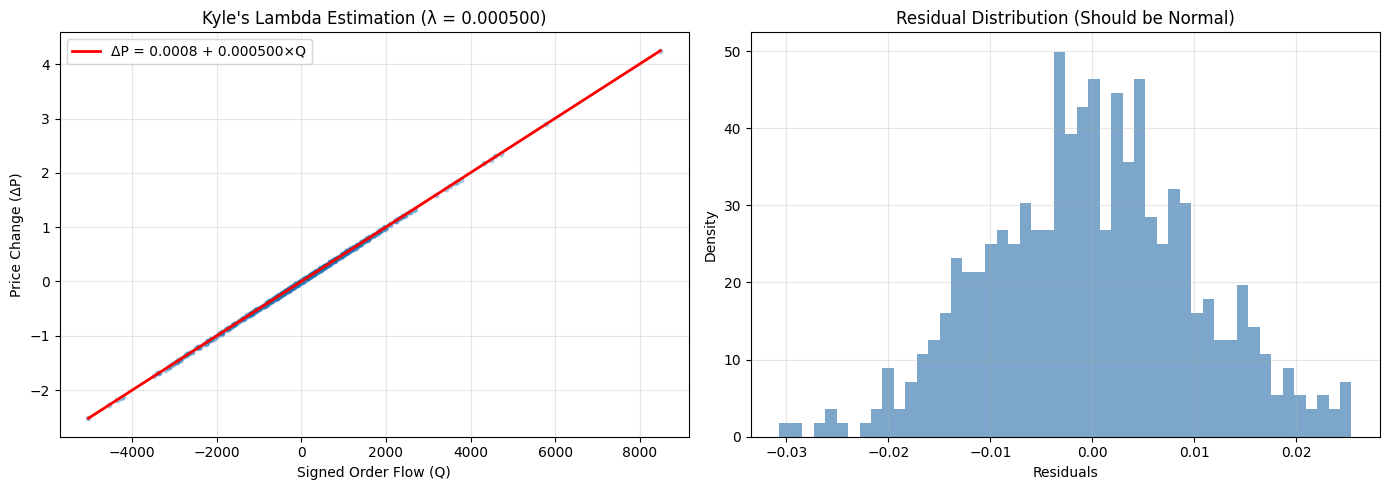

In [6]:
# Question 5: Kyle's Lambda (Price Impact)

def estimate_kyles_lambda(price_changes: np.ndarray, signed_order_flow: np.ndarray) -> dict:
    """
    Estimate Kyle's lambda using OLS regression.
    
    Model: ΔP = λ × Q + ε
    
    Parameters:
    -----------
    price_changes : array - Price changes (ΔP)
    signed_order_flow : array - Signed order flow (positive=buy, negative=sell)
    
    Returns:
    --------
    dict : Lambda estimate, standard error, R-squared, t-statistic
    """
    # OLS regression: ΔP = α + λQ + ε
    n = len(price_changes)
    
    # Add constant for intercept
    X = np.column_stack([np.ones(n), signed_order_flow])
    y = price_changes
    
    # OLS: β = (X'X)^(-1) X'y
    XtX_inv = np.linalg.inv(X.T @ X)
    beta = XtX_inv @ X.T @ y
    
    # Fitted values and residuals
    y_hat = X @ beta
    residuals = y - y_hat
    
    # R-squared
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Standard errors
    sigma_sq = ss_res / (n - 2)
    se = np.sqrt(np.diag(sigma_sq * XtX_inv))
    
    # t-statistics
    t_stats = beta / se
    
    return {
        'alpha': beta[0],
        'lambda': beta[1],
        'se_lambda': se[1],
        't_stat': t_stats[1],
        'r_squared': r_squared,
        'residuals': residuals
    }


# Simulate trade data with Kyle's model
np.random.seed(42)
n_trades = 500

# True Kyle's lambda
true_lambda = 0.0005  # Price impact per share

# Signed order flow: positive = buy, negative = sell
# Mix of informed and noise traders
informed_flow = np.random.choice([-1, 1], n_trades) * np.random.exponential(1000, n_trades)
noise_flow = np.random.randn(n_trades) * 500
signed_order_flow = informed_flow + noise_flow

# Price changes according to Kyle's model
noise_price = np.random.randn(n_trades) * 0.01
price_changes = true_lambda * signed_order_flow + noise_price

# Estimate Kyle's lambda
results = estimate_kyles_lambda(price_changes, signed_order_flow)

print("=" * 60)
print("KYLE'S LAMBDA ESTIMATION")
print("=" * 60)
print(f"\nTrue λ (simulation):     {true_lambda:.6f}")
print(f"Estimated λ:             {results['lambda']:.6f}")
print(f"Standard Error:          {results['se_lambda']:.6f}")
print(f"t-statistic:             {results['t_stat']:.2f}")
print(f"R-squared:               {results['r_squared']:.4f}")
print(f"Alpha (intercept):       {results['alpha']:.6f}")

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)
print(f"\n• A $1,000 buy order moves price by: ${results['lambda'] * 1000:.4f}")
print(f"• A $10,000 buy order moves price by: ${results['lambda'] * 10000:.4f}")

# Liquidity interpretation
if results['lambda'] < 0.0003:
    liquidity = "HIGH liquidity (low impact)"
elif results['lambda'] < 0.001:
    liquidity = "MODERATE liquidity"
else:
    liquidity = "LOW liquidity (high impact)"
print(f"• Market Liquidity Assessment: {liquidity}")

# Compare across different stocks
print("\n" + "=" * 60)
print("LAMBDA COMPARISON ACROSS STOCKS")
print("=" * 60)

stocks = {
    'AAPL (Large Cap)': 0.00001,
    'MSFT (Large Cap)': 0.00002,
    'Small Cap Stock': 0.001,
    'Penny Stock': 0.01
}

print(f"\n{'Stock':<25} {'λ':>12} {'$10K Impact':>15} {'Liquidity':>15}")
print("-" * 70)
for stock, lam in stocks.items():
    impact = lam * 10000
    liq = "High" if lam < 0.0001 else "Low" if lam > 0.001 else "Medium"
    print(f"{stock:<25} {lam:>12.6f} ${impact:>13.4f} {liq:>15}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with regression line
axes[0].scatter(signed_order_flow, price_changes, alpha=0.3, s=10)
x_line = np.linspace(signed_order_flow.min(), signed_order_flow.max(), 100)
y_line = results['alpha'] + results['lambda'] * x_line
axes[0].plot(x_line, y_line, 'r-', linewidth=2, 
             label=f"ΔP = {results['alpha']:.4f} + {results['lambda']:.6f}×Q")
axes[0].set_xlabel('Signed Order Flow (Q)')
axes[0].set_ylabel('Price Change (ΔP)')
axes[0].set_title(f"Kyle's Lambda Estimation (λ = {results['lambda']:.6f})")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
axes[1].hist(results['residuals'], bins=50, density=True, alpha=0.7, color='steelblue')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Residual Distribution (Should be Normal)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Question 6: Roll's Spread Estimator

### Interview Question:
*"Implement Roll's model to estimate effective spread from trade prices using autocovariance of returns."*

### Key Concepts:
- **Roll (1984)**: Estimate spread when only trade prices are observed (no quotes)
- **Key Insight**: Trade bounces between bid and ask create negative autocorrelation
- **Formula**: $Spread = 2\sqrt{-Cov(r_t, r_{t-1})}$
  - Only valid when autocovariance is negative
  
### Assumptions:
1. Trades alternate between bid and ask
2. Efficient market (no information in trade direction)
3. No serial correlation in "true" returns

### Practical Notes:
- Works best for liquid markets
- May fail (imaginary) if positive autocorrelation (momentum)
- Underestimates spread in trending markets

ROLL'S SPREAD ESTIMATOR

Simulation Parameters:
  Number of trades: 1000
  True spread: 0.0010 (10.0 bps)

Estimation Results:
  Estimated spread: 0.000938 (9.38 bps)
  True spread:      0.001000 (10.0 bps)
  Estimation error: -0.62 bps

  Autocovariance:   -0.00000022
  Autocorrelation:  -0.4657
  Valid estimate:   True

WHY ROLL'S MODEL WORKS

When trades bounce between bid and ask:

1. Buy (at ask) followed by Sell (at bid):
   Return ≈ -spread (negative)

2. Sell (at bid) followed by Buy (at ask):
   Return ≈ +spread (positive)

3. Same direction trades:
   Return ≈ 0 (small)

This pattern creates NEGATIVE autocorrelation in returns!

SPREAD ESTIMATION ACROSS DIFFERENT MARKETS

True Spread (bps)    Estimated (bps)      Error (bps)    
-------------------------------------------------------
1.0                  0.97                 -0.03          
5.0                  5.29                 0.29           
10.0                 9.62                 -0.38          
50.0                 

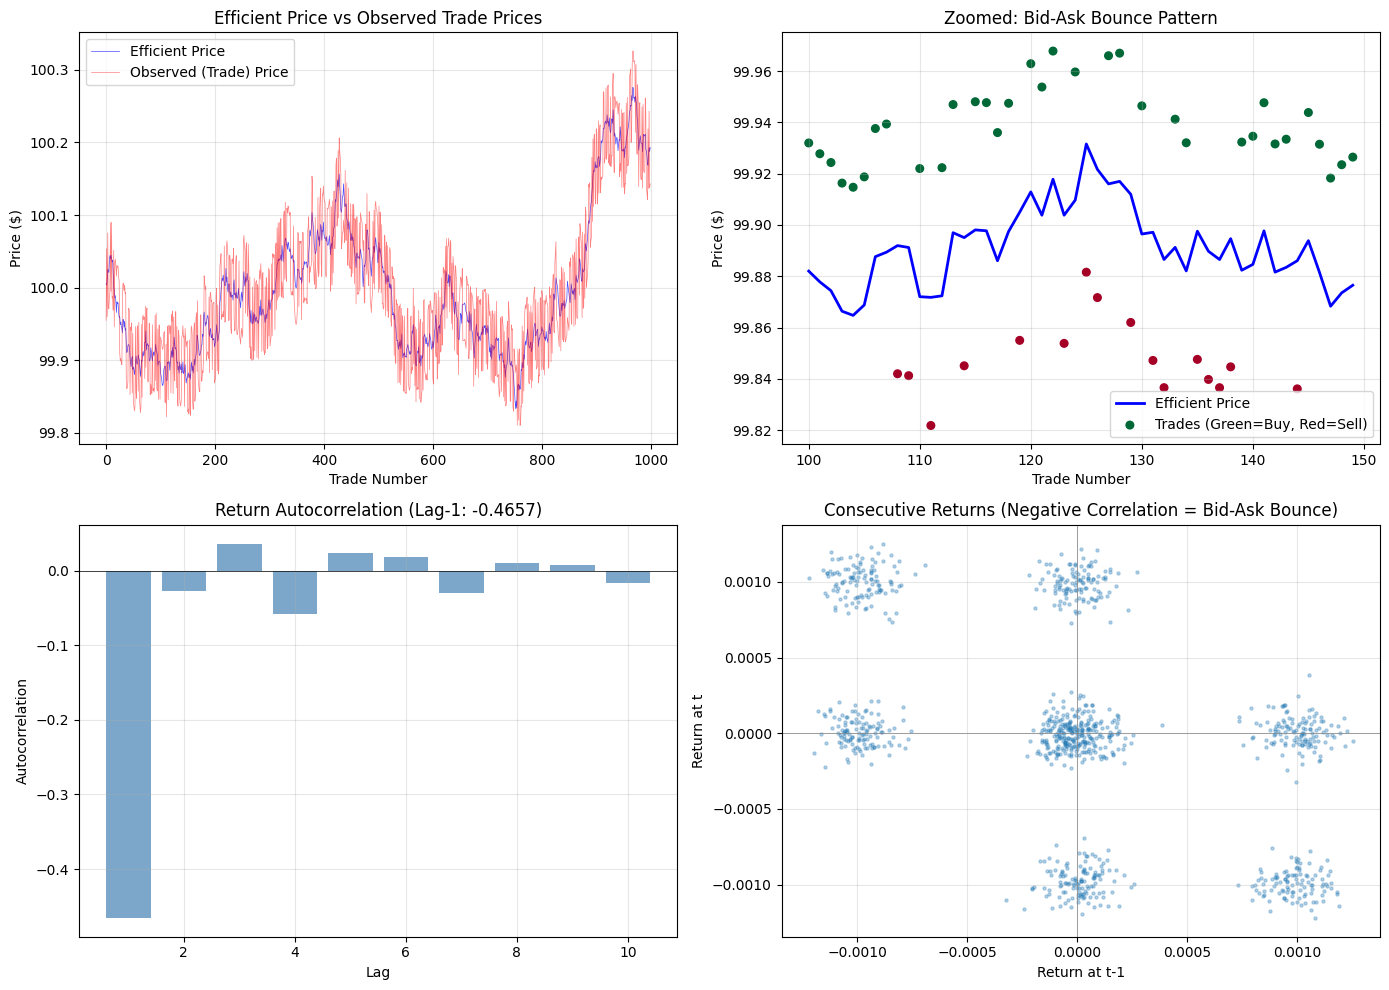

In [7]:
# Question 6: Roll's Spread Estimator

def roll_spread_estimator(prices: np.ndarray) -> dict:
    """
    Estimate effective spread using Roll's (1984) model.
    
    Spread = 2 × sqrt(-Cov(r_t, r_{t-1}))
    
    Based on the insight that bid-ask bounce creates negative
    autocorrelation in returns.
    
    Parameters:
    -----------
    prices : array - Transaction prices
    
    Returns:
    --------
    dict : Estimated spread and related statistics
    """
    # Calculate returns
    returns = np.diff(prices) / prices[:-1]
    
    # Autocovariance at lag 1
    mean_ret = np.mean(returns)
    autocov = np.mean((returns[1:] - mean_ret) * (returns[:-1] - mean_ret))
    
    # Roll's spread estimate
    if autocov < 0:
        spread = 2 * np.sqrt(-autocov)
        valid = True
    else:
        spread = np.nan
        valid = False
    
    # Autocorrelation
    autocorr = autocov / np.var(returns)
    
    return {
        'spread': spread,
        'spread_pct': spread * 100 if valid else np.nan,
        'autocovariance': autocov,
        'autocorrelation': autocorr,
        'valid': valid,
        'n_trades': len(prices)
    }


def simulate_roll_model(n_trades: int, true_spread: float, 
                         mid_price: float = 100.0,
                         volatility: float = 0.0001) -> np.ndarray:
    """
    Simulate trade prices following Roll's assumptions.
    
    Parameters:
    -----------
    n_trades : int - Number of trades
    true_spread : float - True bid-ask spread (decimal)
    mid_price : float - Starting mid price
    volatility : float - Volatility of efficient price
    """
    # Efficient price (random walk)
    efficient_returns = np.random.randn(n_trades) * volatility
    efficient_price = mid_price * np.cumprod(1 + efficient_returns)
    
    # Trade direction: +1 (buy at ask) or -1 (sell at bid)
    trade_direction = np.random.choice([-1, 1], n_trades)
    
    # Observed price = efficient price + half spread × direction
    half_spread = true_spread / 2
    observed_prices = efficient_price * (1 + half_spread * trade_direction)
    
    return observed_prices, efficient_price, trade_direction


# Simulate and estimate
np.random.seed(42)
n_trades = 1000
true_spread = 0.001  # 0.1% or 10 bps

observed_prices, efficient_prices, directions = simulate_roll_model(
    n_trades, true_spread, mid_price=100.0, volatility=0.0001
)

# Estimate spread
results = roll_spread_estimator(observed_prices)

print("=" * 60)
print("ROLL'S SPREAD ESTIMATOR")
print("=" * 60)
print(f"\nSimulation Parameters:")
print(f"  Number of trades: {n_trades}")
print(f"  True spread: {true_spread:.4f} ({true_spread*10000:.1f} bps)")

print(f"\nEstimation Results:")
print(f"  Estimated spread: {results['spread']:.6f} ({results['spread']*10000:.2f} bps)")
print(f"  True spread:      {true_spread:.6f} ({true_spread*10000:.1f} bps)")
print(f"  Estimation error: {(results['spread'] - true_spread)*10000:.2f} bps")
print(f"\n  Autocovariance:   {results['autocovariance']:.8f}")
print(f"  Autocorrelation:  {results['autocorrelation']:.4f}")
print(f"  Valid estimate:   {results['valid']}")

# Show why Roll's model works
print("\n" + "=" * 60)
print("WHY ROLL'S MODEL WORKS")
print("=" * 60)
print("""
When trades bounce between bid and ask:

1. Buy (at ask) followed by Sell (at bid):
   Return ≈ -spread (negative)
   
2. Sell (at bid) followed by Buy (at ask):
   Return ≈ +spread (positive)
   
3. Same direction trades:
   Return ≈ 0 (small)
   
This pattern creates NEGATIVE autocorrelation in returns!
""")

# Test with different spread levels
print("=" * 60)
print("SPREAD ESTIMATION ACROSS DIFFERENT MARKETS")
print("=" * 60)

test_spreads = [0.0001, 0.0005, 0.001, 0.005, 0.01]
print(f"\n{'True Spread (bps)':<20} {'Estimated (bps)':<20} {'Error (bps)':<15}")
print("-" * 55)

for true_sp in test_spreads:
    prices, _, _ = simulate_roll_model(1000, true_sp)
    est = roll_spread_estimator(prices)
    error = (est['spread'] - true_sp) * 10000 if est['valid'] else np.nan
    print(f"{true_sp*10000:<20.1f} {est['spread']*10000:<20.2f} {error:<15.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Observed vs Efficient Price
axes[0, 0].plot(efficient_prices, 'b-', alpha=0.7, label='Efficient Price', linewidth=0.5)
axes[0, 0].plot(observed_prices, 'r-', alpha=0.5, label='Observed (Trade) Price', linewidth=0.5)
axes[0, 0].set_xlabel('Trade Number')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].set_title('Efficient Price vs Observed Trade Prices')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Zoom in on bid-ask bounce
zoom_start, zoom_end = 100, 150
axes[0, 1].plot(range(zoom_start, zoom_end), efficient_prices[zoom_start:zoom_end], 
                'b-', linewidth=2, label='Efficient Price')
axes[0, 1].scatter(range(zoom_start, zoom_end), observed_prices[zoom_start:zoom_end],
                   c=directions[zoom_start:zoom_end], cmap='RdYlGn', 
                   s=30, label='Trades (Green=Buy, Red=Sell)')
axes[0, 1].set_xlabel('Trade Number')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].set_title('Zoomed: Bid-Ask Bounce Pattern')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Returns autocorrelation
returns = np.diff(observed_prices) / observed_prices[:-1]
lags = range(1, 11)
autocorrs = [np.corrcoef(returns[lag:], returns[:-lag])[0, 1] for lag in lags]

axes[1, 0].bar(lags, autocorrs, color='steelblue', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Autocorrelation')
axes[1, 0].set_title(f'Return Autocorrelation (Lag-1: {autocorrs[0]:.4f})')
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot of consecutive returns
axes[1, 1].scatter(returns[:-1], returns[1:], alpha=0.3, s=5)
axes[1, 1].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[1, 1].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
axes[1, 1].set_xlabel('Return at t-1')
axes[1, 1].set_ylabel('Return at t')
axes[1, 1].set_title('Consecutive Returns (Negative Correlation = Bid-Ask Bounce)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Question 7: Realized Volatility from Tick Data

### Interview Question:
*"Calculate realized volatility at different sampling frequencies. What is microstructure noise and how does it affect optimal sampling?"*

### Key Concepts:
- **Realized Volatility (RV)**: $RV = \sum_{i=1}^{n} r_i^2$
- **Sampling Frequency**: How often to sample prices (1-min, 5-min, etc.)
- **Microstructure Noise**: Bid-ask bounce, discrete prices, delays

### The Volatility Signature Plot:
- **High frequency** (tick-by-tick): RV inflated by microstructure noise
- **Low frequency** (daily): Loses information, high variance
- **Optimal frequency**: ~5-15 minutes balances bias vs variance

### Advanced Estimators:
- **Two-scale RV**: Uses multiple frequencies
- **Realized Kernel**: Noise-robust estimator
- **Pre-averaging**: Averages prices before computing RV

REALIZED VOLATILITY ANALYSIS

Simulation Setup:
  Number of ticks: 23,400
  True annualized volatility: 20.0%
  Microstructure noise: 1.0 bps

VOLATILITY SIGNATURE PLOT DATA

Frequency       Sampling        Ann. Vol        vs True        
------------------------------------------------------------
1s                       1 ticks 39.68%      +19.68%
5s                       5 ticks 24.83%      +4.83%
10s                     10 ticks 22.44%      +2.44%
30s                     30 ticks 20.71%      +0.71%
1min                    60 ticks 20.36%      +0.36%
2min                   120 ticks 19.24%      -0.76%
5min                   300 ticks 17.07%      -2.93%
10min                  600 ticks 18.73%      -1.27%
30min                 1800 ticks 23.42%      +3.42%
1hr                   3600 ticks 25.40%      +5.40%

MICROSTRUCTURE NOISE EFFECT

Why volatility is INFLATED at high frequencies:

1. Bid-ask bounce: Price jumps between bid and ask
2. Discrete prices: Prices round to tick sizes
3.

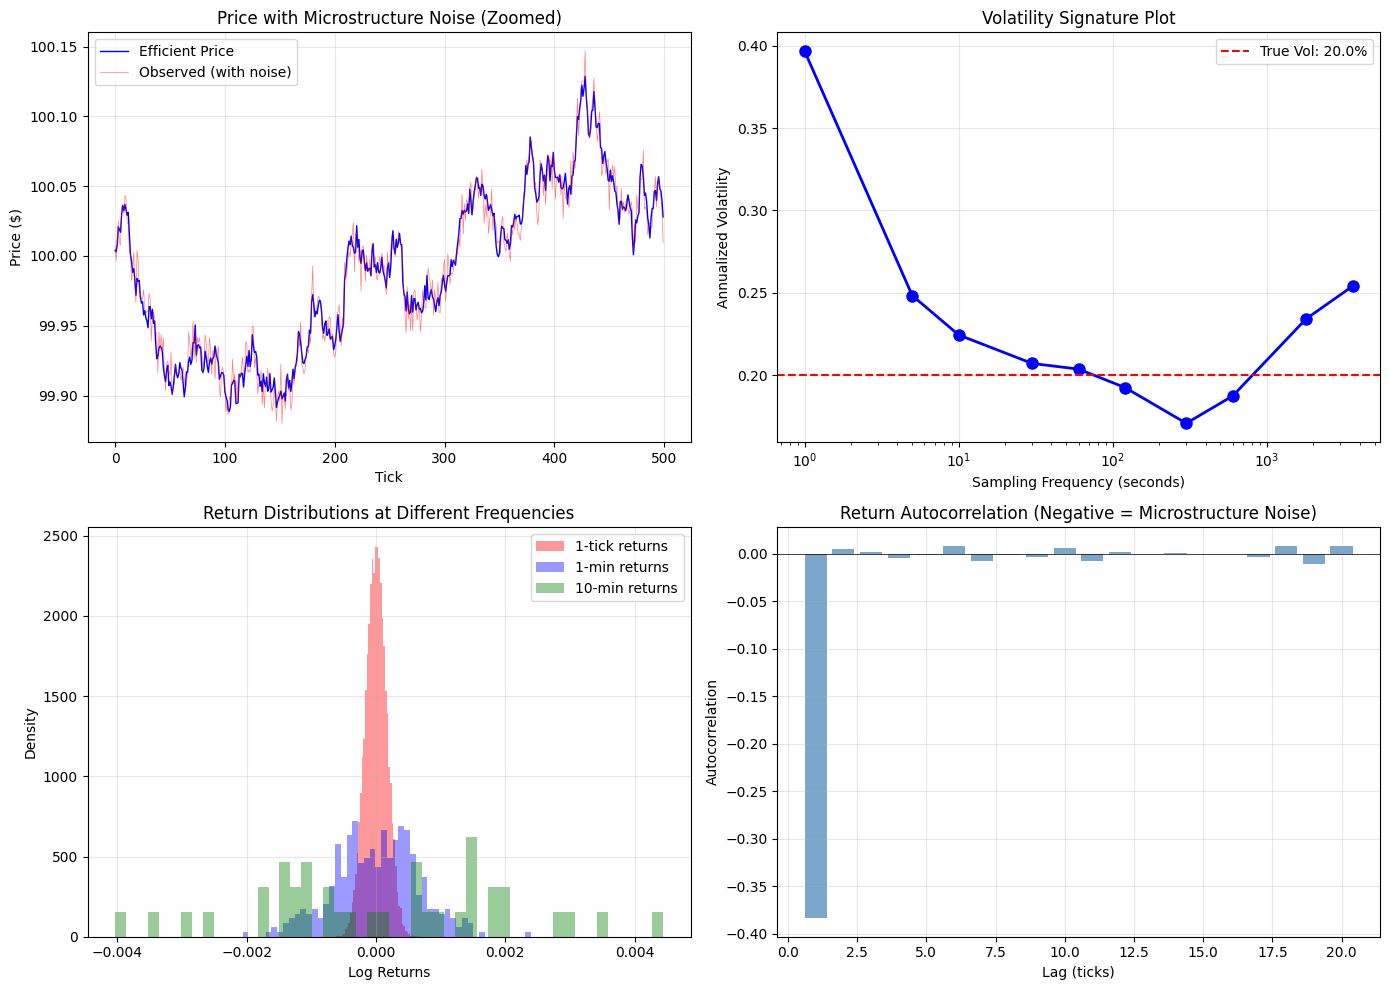

In [8]:
# Question 7: Realized Volatility from Tick Data

def calculate_realized_volatility(prices: np.ndarray) -> float:
    """
    Calculate realized volatility as sum of squared log returns.
    
    RV = Σ r_i²
    
    where r_i = log(P_i / P_{i-1})
    """
    log_returns = np.diff(np.log(prices))
    return np.sum(log_returns ** 2)


def calculate_rv_at_frequency(prices: np.ndarray, sampling_freq: int) -> float:
    """
    Calculate RV by sampling at given frequency.
    
    Parameters:
    -----------
    prices : array - High-frequency prices
    sampling_freq : int - Sample every n-th price
    
    Returns:
    --------
    float : Annualized volatility
    """
    sampled_prices = prices[::sampling_freq]
    if len(sampled_prices) < 2:
        return np.nan
    
    log_returns = np.diff(np.log(sampled_prices))
    rv = np.sum(log_returns ** 2)
    
    # Annualize (assuming 252 trading days, 6.5 hours per day)
    n_samples_per_day = len(sampled_prices)
    daily_rv = rv  # This is for one day's data
    annualized_vol = np.sqrt(daily_rv * 252)
    
    return annualized_vol


def simulate_prices_with_noise(n_ticks: int, true_vol: float, noise_std: float) -> tuple:
    """
    Simulate tick prices with microstructure noise.
    
    Parameters:
    -----------
    n_ticks : int - Number of tick observations
    true_vol : float - True daily volatility
    noise_std : float - Microstructure noise standard deviation
    """
    # Efficient price (true signal)
    # Daily vol -> per-tick vol
    tick_vol = true_vol / np.sqrt(n_ticks * 252)
    true_returns = np.random.randn(n_ticks) * tick_vol
    efficient_price = 100 * np.cumprod(1 + true_returns)
    
    # Add microstructure noise (bid-ask bounce, etc.)
    noise = np.random.randn(n_ticks) * noise_std
    observed_price = efficient_price * (1 + noise)
    
    return observed_price, efficient_price


# Simulate intraday tick data (1 day, ~6.5 hours, tick-by-tick)
np.random.seed(42)
n_ticks = 23400  # About 1 tick per second for 6.5 hours
true_daily_vol = 0.20  # 20% annualized volatility
noise_level = 0.0001  # 1 bps noise

observed_prices, efficient_prices = simulate_prices_with_noise(
    n_ticks, true_daily_vol, noise_level
)

print("=" * 60)
print("REALIZED VOLATILITY ANALYSIS")
print("=" * 60)
print(f"\nSimulation Setup:")
print(f"  Number of ticks: {n_ticks:,}")
print(f"  True annualized volatility: {true_daily_vol:.1%}")
print(f"  Microstructure noise: {noise_level*10000:.1f} bps")

# Calculate RV at different sampling frequencies
frequencies = [1, 5, 10, 30, 60, 120, 300, 600, 1800, 3600]
freq_labels = ['1s', '5s', '10s', '30s', '1min', '2min', '5min', '10min', '30min', '1hr']

rv_estimates = []
for freq in frequencies:
    rv = calculate_rv_at_frequency(observed_prices, freq)
    rv_estimates.append(rv)

print("\n" + "=" * 60)
print("VOLATILITY SIGNATURE PLOT DATA")
print("=" * 60)
print(f"\n{'Frequency':<15} {'Sampling':<15} {'Ann. Vol':<15} {'vs True':<15}")
print("-" * 60)
for label, freq, rv in zip(freq_labels, frequencies, rv_estimates):
    if not np.isnan(rv):
        diff = rv - true_daily_vol
        print(f"{label:<15} {freq:>10} ticks {rv:.2%}{' '*5} {diff:+.2%}")

# Theoretical optimal frequency
print("\n" + "=" * 60)
print("MICROSTRUCTURE NOISE EFFECT")
print("=" * 60)
print("""
Why volatility is INFLATED at high frequencies:

1. Bid-ask bounce: Price jumps between bid and ask
2. Discrete prices: Prices round to tick sizes
3. Stale quotes: Quotes don't update instantaneously

At tick-by-tick:
  - Noise dominates, RV >> true vol
  
At very low frequency (e.g., hourly):
  - Less bias, but higher variance
  
Optimal: ~5-15 minutes (empirically)
""")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Prices (zoomed)
zoom_ticks = 500
axes[0, 0].plot(efficient_prices[:zoom_ticks], 'b-', label='Efficient Price', linewidth=1)
axes[0, 0].plot(observed_prices[:zoom_ticks], 'r-', alpha=0.5, label='Observed (with noise)', linewidth=0.5)
axes[0, 0].set_xlabel('Tick')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].set_title('Price with Microstructure Noise (Zoomed)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Volatility Signature Plot
valid_mask = ~np.isnan(rv_estimates)
axes[0, 1].semilogx([f for f, v in zip(frequencies, valid_mask) if v],
                     [rv for rv, v in zip(rv_estimates, valid_mask) if v], 
                     'bo-', markersize=8, linewidth=2)
axes[0, 1].axhline(y=true_daily_vol, color='r', linestyle='--', 
                    label=f'True Vol: {true_daily_vol:.1%}')
axes[0, 1].set_xlabel('Sampling Frequency (seconds)')
axes[0, 1].set_ylabel('Annualized Volatility')
axes[0, 1].set_title('Volatility Signature Plot')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Returns distribution at different frequencies
for freq, label, color in [(1, '1-tick', 'red'), (60, '1-min', 'blue'), (600, '10-min', 'green')]:
    sampled = observed_prices[::freq]
    rets = np.diff(np.log(sampled))
    axes[1, 0].hist(rets, bins=50, alpha=0.4, label=f'{label} returns', density=True, color=color)
axes[1, 0].set_xlabel('Log Returns')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Return Distributions at Different Frequencies')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Autocorrelation of returns at tick level (showing noise)
tick_returns = np.diff(np.log(observed_prices))
lags = range(1, 21)
autocorrs = [np.corrcoef(tick_returns[lag:], tick_returns[:-lag])[0, 1] for lag in lags]

axes[1, 1].bar(lags, autocorrs, color='steelblue', alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].set_xlabel('Lag (ticks)')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].set_title('Return Autocorrelation (Negative = Microstructure Noise)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Question 8: Trade Classification (Lee-Ready Algorithm)

### Interview Question:
*"Implement the Lee-Ready algorithm to classify trades as buyer or seller initiated using quote and tick rules."*

### Key Concepts:
- **Purpose**: Determine trade initiator (buyer or seller) for order flow analysis
- **Quote Rule**: Compare trade price to midpoint
  - Trade > Mid → Buyer initiated
  - Trade < Mid → Seller initiated
- **Tick Rule**: If trade = mid, use price change
  - Uptick → Buyer initiated
  - Downtick → Seller initiated
- **Lee-Ready**: Combines both rules with 5-second quote lag

### Applications:
1. Calculate signed order flow for Kyle's lambda
2. Measure buy/sell imbalance
3. Estimate trading costs and price impact
4. Detect informed trading patterns

LEE-READY TRADE CLASSIFICATION

Sample Classified Trades:
----------------------------------------------------------------------
 trade_num      price        bid        mid        ask  quote_sign  tick_sign  lee_ready_sign initiator
         1 100.024967  99.984967 100.004967 100.024967           1   1.000000        1.000000     BUYER
         2  99.983584  99.983584 100.003584 100.023584          -1  -1.000000       -1.000000    SELLER
         3  99.990061  99.990061 100.010061 100.030061          -1   1.000000       -1.000000    SELLER
         4 100.005292 100.005292 100.025292 100.045292          -1   1.000000       -1.000000    SELLER
         5 100.034743 100.002950 100.022950 100.042950           1   1.000000        1.000000     BUYER
         6 100.000609 100.000609 100.020609 100.040609          -1  -1.000000       -1.000000    SELLER
         7 100.056401 100.016401 100.036401 100.056401           1   1.000000        1.000000     BUYER
         8 100.044075 100.024075 100.04

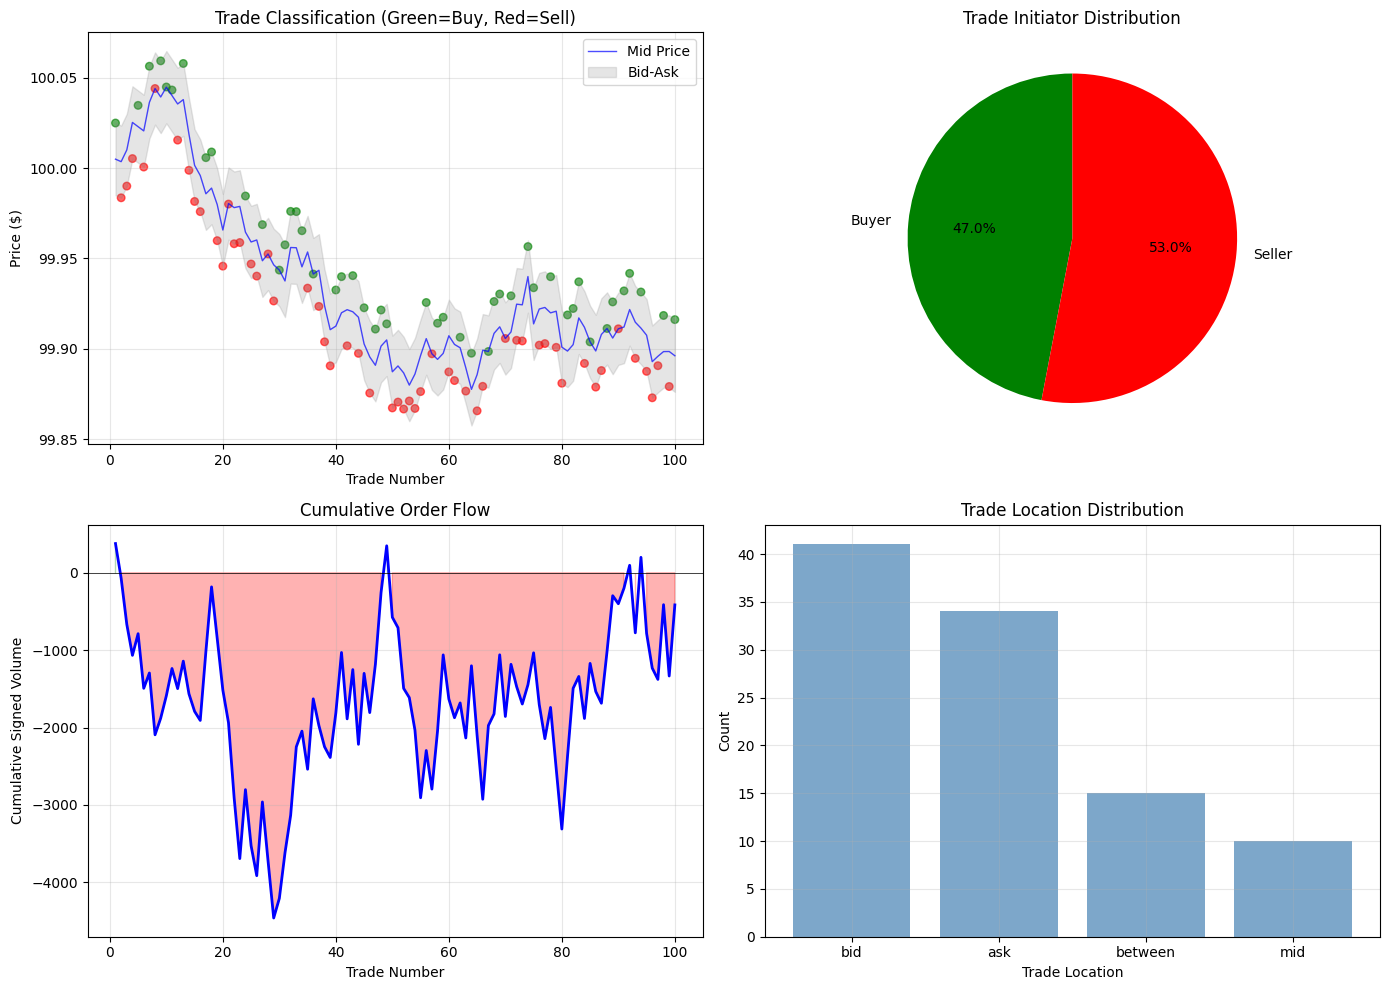

In [9]:
# Question 8: Trade Classification (Lee-Ready Algorithm)

def quote_rule(trade_price: float, bid: float, ask: float) -> int:
    """
    Quote rule: Classify trade based on position relative to quotes.
    
    Returns:
    --------
    +1: Buyer initiated (trade at or above midpoint)
    -1: Seller initiated (trade at or below midpoint)
     0: At midpoint (need tick rule)
    """
    mid = (bid + ask) / 2
    
    if trade_price > mid:
        return 1  # Buyer initiated
    elif trade_price < mid:
        return -1  # Seller initiated
    else:
        return 0  # At midpoint - use tick rule


def tick_rule(current_price: float, previous_price: float, 
              last_direction: int = 1) -> int:
    """
    Tick rule: Classify based on price change.
    
    - Uptick (price up): Buyer initiated (+1)
    - Downtick (price down): Seller initiated (-1)
    - Zero tick: Use last non-zero direction
    
    Returns:
    --------
    +1: Buyer initiated
    -1: Seller initiated
    """
    if current_price > previous_price:
        return 1
    elif current_price < previous_price:
        return -1
    else:
        return last_direction  # Zero tick: continue last direction


def lee_ready_classification(trades_df: pd.DataFrame) -> pd.DataFrame:
    """
    Lee-Ready algorithm for trade classification.
    
    Combines quote rule and tick rule:
    1. Use quote rule if trade is not at midpoint
    2. If at midpoint, use tick rule
    
    Expected columns: 'price', 'bid', 'ask'
    """
    df = trades_df.copy()
    
    # Calculate midpoint
    df['mid'] = (df['bid'] + df['ask']) / 2
    
    # Quote rule
    df['quote_sign'] = np.where(df['price'] > df['mid'], 1,
                                np.where(df['price'] < df['mid'], -1, 0))
    
    # Tick rule (for trades at midpoint)
    df['price_change'] = df['price'].diff()
    df['tick_sign'] = np.sign(df['price_change'])
    
    # Handle zero ticks (carry forward last non-zero)
    df['tick_sign'] = df['tick_sign'].replace(0, np.nan).ffill().fillna(1)
    
    # Lee-Ready: Use quote rule, fall back to tick rule at midpoint
    df['lee_ready_sign'] = np.where(df['quote_sign'] != 0, 
                                     df['quote_sign'], 
                                     df['tick_sign'])
    
    # Classification labels
    df['initiator'] = np.where(df['lee_ready_sign'] > 0, 'BUYER', 'SELLER')
    
    return df


# Generate synthetic trade and quote data
np.random.seed(42)
n_trades = 100

# Simulate quotes
base_price = 100.0
mid_prices = base_price + np.cumsum(np.random.randn(n_trades) * 0.01)
half_spread = 0.02  # 2 cents spread

bids = mid_prices - half_spread
asks = mid_prices + half_spread

# Simulate trade prices (sometimes at bid, ask, or in between)
trade_locations = np.random.choice(['bid', 'ask', 'mid', 'between'], 
                                    n_trades, p=[0.35, 0.35, 0.15, 0.15])
trade_prices = np.zeros(n_trades)

for i in range(n_trades):
    if trade_locations[i] == 'bid':
        trade_prices[i] = bids[i]
    elif trade_locations[i] == 'ask':
        trade_prices[i] = asks[i]
    elif trade_locations[i] == 'mid':
        trade_prices[i] = mid_prices[i]
    else:  # between
        trade_prices[i] = mid_prices[i] + np.random.uniform(-half_spread, half_spread)

# Create DataFrame
trades_df = pd.DataFrame({
    'trade_num': range(1, n_trades + 1),
    'price': trade_prices,
    'bid': bids,
    'ask': asks,
    'volume': np.random.randint(100, 1000, n_trades)
})

# Apply Lee-Ready classification
classified_df = lee_ready_classification(trades_df)

print("=" * 70)
print("LEE-READY TRADE CLASSIFICATION")
print("=" * 70)

# Show first few trades
print("\nSample Classified Trades:")
print("-" * 70)
display_cols = ['trade_num', 'price', 'bid', 'mid', 'ask', 'quote_sign', 
                'tick_sign', 'lee_ready_sign', 'initiator']
print(classified_df[display_cols].head(15).to_string(index=False))

# Summary statistics
print("\n" + "=" * 70)
print("CLASSIFICATION SUMMARY")
print("=" * 70)
buyer_count = (classified_df['lee_ready_sign'] > 0).sum()
seller_count = (classified_df['lee_ready_sign'] < 0).sum()

print(f"\nTotal trades: {n_trades}")
print(f"Buyer initiated: {buyer_count} ({buyer_count/n_trades:.1%})")
print(f"Seller initiated: {seller_count} ({seller_count/n_trades:.1%})")

# Signed order flow
signed_volume = (classified_df['lee_ready_sign'] * classified_df['volume']).sum()
total_volume = classified_df['volume'].sum()
print(f"\nTotal volume: {total_volume:,}")
print(f"Signed order flow: {signed_volume:+,}")
print(f"Order flow imbalance: {signed_volume/total_volume:+.2%}")

# Quote rule vs tick rule usage
quote_rule_used = (classified_df['quote_sign'] != 0).sum()
tick_rule_used = n_trades - quote_rule_used
print(f"\nQuote rule used: {quote_rule_used} trades ({quote_rule_used/n_trades:.1%})")
print(f"Tick rule used: {tick_rule_used} trades ({tick_rule_used/n_trades:.1%})")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trade prices with classification
colors = ['green' if s > 0 else 'red' for s in classified_df['lee_ready_sign']]
axes[0, 0].scatter(classified_df['trade_num'], classified_df['price'], 
                   c=colors, alpha=0.6, s=30)
axes[0, 0].plot(classified_df['trade_num'], classified_df['mid'], 'b-', 
                linewidth=1, label='Mid Price', alpha=0.7)
axes[0, 0].fill_between(classified_df['trade_num'], classified_df['bid'], 
                         classified_df['ask'], alpha=0.2, color='gray', label='Bid-Ask')
axes[0, 0].set_xlabel('Trade Number')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].set_title('Trade Classification (Green=Buy, Red=Sell)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Classification breakdown
categories = ['Buyer', 'Seller']
counts = [buyer_count, seller_count]
colors_pie = ['green', 'red']
axes[0, 1].pie(counts, labels=categories, colors=colors_pie, autopct='%1.1f%%',
               startangle=90)
axes[0, 1].set_title('Trade Initiator Distribution')

# Cumulative signed order flow
cumulative_flow = (classified_df['lee_ready_sign'] * classified_df['volume']).cumsum()
axes[1, 0].plot(classified_df['trade_num'], cumulative_flow, 'b-', linewidth=2)
axes[1, 0].fill_between(classified_df['trade_num'], 0, cumulative_flow, 
                         where=cumulative_flow > 0, alpha=0.3, color='green')
axes[1, 0].fill_between(classified_df['trade_num'], 0, cumulative_flow, 
                         where=cumulative_flow < 0, alpha=0.3, color='red')
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].set_xlabel('Trade Number')
axes[1, 0].set_ylabel('Cumulative Signed Volume')
axes[1, 0].set_title('Cumulative Order Flow')
axes[1, 0].grid(True, alpha=0.3)

# Trade location histogram
location_counts = pd.Series(trade_locations).value_counts()
axes[1, 1].bar(location_counts.index, location_counts.values, color='steelblue', alpha=0.7)
axes[1, 1].set_xlabel('Trade Location')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Trade Location Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Question 9: Amihud Illiquidity Measure

### Interview Question:
*"Calculate Amihud's illiquidity ratio. What does it measure and how is it interpreted?"*

### Key Concepts:
- **Amihud (2002)**: Simple, widely-used illiquidity measure
- **Formula**: $ILLIQ = \frac{1}{D} \sum_{d=1}^{D} \frac{|r_d|}{Volume_d}$
- **Interpretation**: Price impact per dollar traded
- **Units**: Typically multiplied by 10^6 for readability

### Why It Works:
- Captures the intuition that illiquid stocks move more per unit volume
- Requires only daily price and volume data (easy to compute)
- Strongly correlated with more sophisticated measures

### Interpretation:
- **Higher ILLIQ** → Less liquid → More price impact
- **Lower ILLIQ** → More liquid → Less price impact
- Cross-sectional: Small caps typically have higher ILLIQ
- Time-series: ILLIQ increases during market stress

AMIHUD ILLIQUIDITY MEASURE

Stock           Avg Volume      Daily Vol    ILLIQ (×10⁶)   
------------------------------------------------------------
AAPL            $50.0B         2.0%        0.0000
MSFT            $30.0B         1.8%        0.0000
MID_CAP         $0.5B         2.5%        0.0000
SMALL_CAP       $0.0B         3.5%        0.0029
MICRO_CAP       $0.0B         5.0%        0.0397

INTERPRETATION GUIDE

Amihud ILLIQ × 10⁶ Interpretation:
  < 0.01    : Very liquid (large cap stocks)
  0.01-0.1  : Liquid
  0.1-1.0   : Moderately liquid
  1.0-10    : Illiquid (small caps)
  > 10      : Very illiquid (micro caps, distressed)

Key insight: ILLIQ measures price impact per $1M traded
  - AAPL: Trading $1M moves price ~0.0001%
  - Micro cap: Trading $1M moves price ~1%

TIME-VARYING LIQUIDITY (STRESS SCENARIO)

Normal Period ILLIQ: 0.0000
Stress Period ILLIQ: 0.0000
ILLIQ Increase During Stress: 3.8x


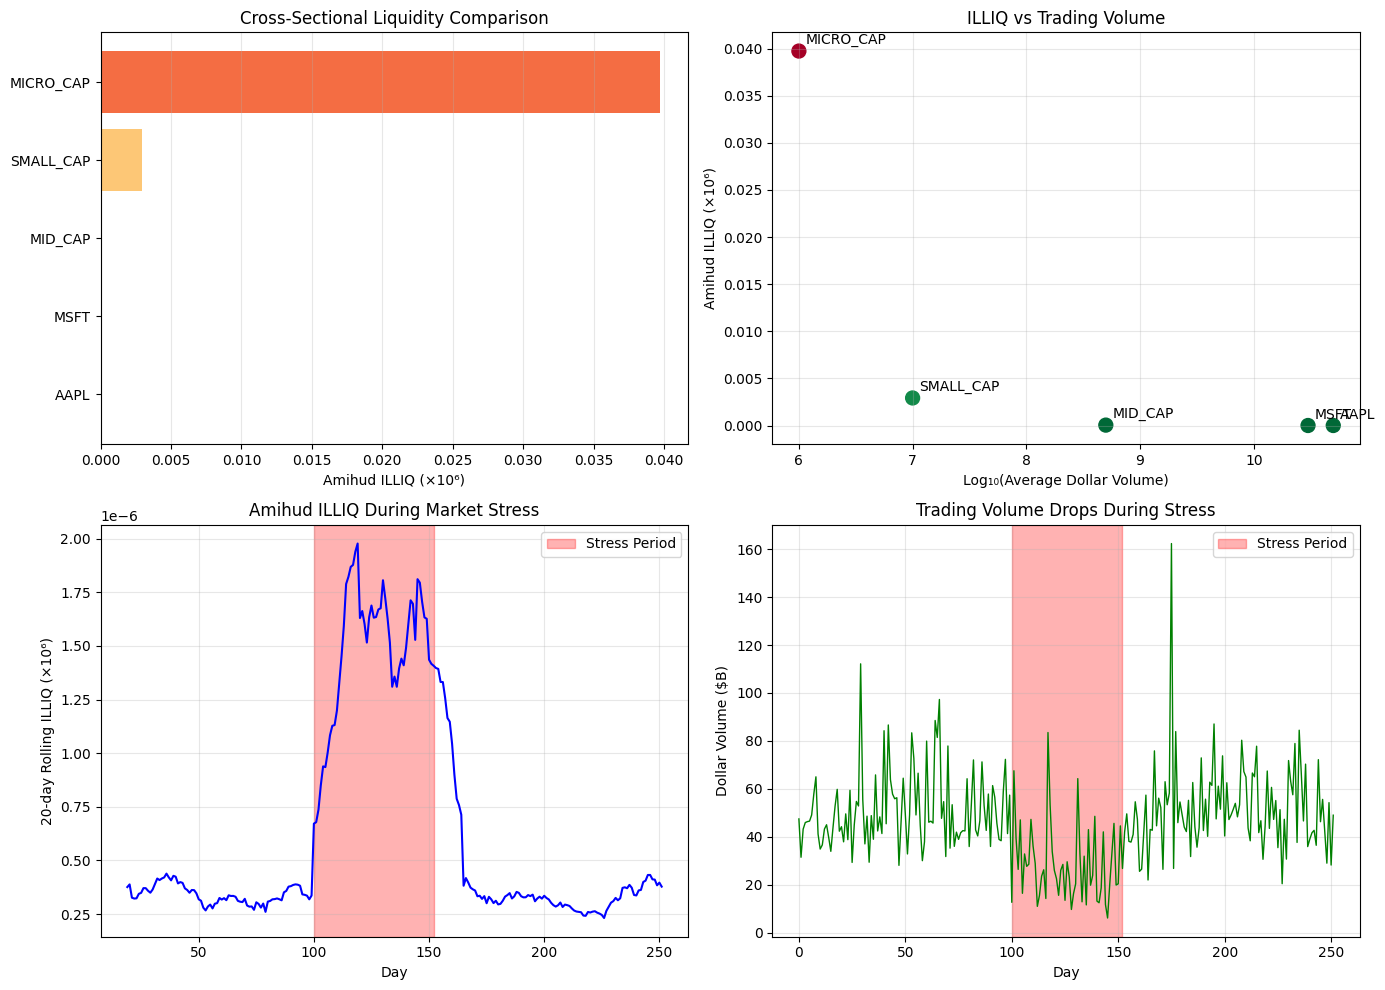

In [10]:
# Question 9: Amihud Illiquidity Measure

def calculate_amihud_illiquidity(returns: np.ndarray, dollar_volumes: np.ndarray,
                                  scale: float = 1e6) -> float:
    """
    Calculate Amihud Illiquidity Ratio.
    
    ILLIQ = (1/D) × Σ |r_d| / Volume_d
    
    Parameters:
    -----------
    returns : array - Daily returns
    dollar_volumes : array - Daily dollar trading volume
    scale : float - Scaling factor (default 10^6)
    
    Returns:
    --------
    float : Amihud illiquidity measure (scaled)
    """
    # Filter out zero volume days
    valid = dollar_volumes > 0
    valid_returns = np.abs(returns[valid])
    valid_volumes = dollar_volumes[valid]
    
    # Amihud ratio
    daily_ratios = valid_returns / valid_volumes
    illiq = np.mean(daily_ratios) * scale
    
    return illiq


def calculate_rolling_amihud(df: pd.DataFrame, window: int = 20,
                              scale: float = 1e6) -> pd.Series:
    """
    Calculate rolling Amihud illiquidity over a window.
    """
    df = df.copy()
    df['abs_return'] = df['return'].abs()
    df['ratio'] = df['abs_return'] / df['dollar_volume']
    
    return df['ratio'].rolling(window).mean() * scale


# Simulate daily data for multiple stocks
np.random.seed(42)
n_days = 252  # One year

# Different liquidity profiles
stocks = {
    'AAPL': {'vol': 0.02, 'avg_volume': 50e9},   # Large cap, very liquid
    'MSFT': {'vol': 0.018, 'avg_volume': 30e9},  # Large cap, liquid
    'MID_CAP': {'vol': 0.025, 'avg_volume': 500e6},  # Mid cap
    'SMALL_CAP': {'vol': 0.035, 'avg_volume': 10e6},  # Small cap, illiquid
    'MICRO_CAP': {'vol': 0.05, 'avg_volume': 1e6},   # Micro cap, very illiquid
}

results = {}
all_data = {}

for stock, params in stocks.items():
    # Generate returns
    returns = np.random.randn(n_days) * params['vol']
    
    # Generate volume (log-normal)
    volumes = params['avg_volume'] * np.exp(np.random.randn(n_days) * 0.3)
    
    # Calculate Amihud
    illiq = calculate_amihud_illiquidity(returns, volumes)
    results[stock] = illiq
    
    all_data[stock] = pd.DataFrame({
        'return': returns,
        'dollar_volume': volumes
    })

print("=" * 60)
print("AMIHUD ILLIQUIDITY MEASURE")
print("=" * 60)
print(f"\n{'Stock':<15} {'Avg Volume':<15} {'Daily Vol':<12} {'ILLIQ (×10⁶)':<15}")
print("-" * 60)

for stock in stocks:
    vol = stocks[stock]['vol']
    avg_vol = stocks[stock]['avg_volume']
    illiq = results[stock]
    print(f"{stock:<15} ${avg_vol/1e9:.1f}B{'':<8} {vol:.1%}{'':<7} {illiq:.4f}")

print("\n" + "=" * 60)
print("INTERPRETATION GUIDE")
print("=" * 60)
print("""
Amihud ILLIQ × 10⁶ Interpretation:
  < 0.01    : Very liquid (large cap stocks)
  0.01-0.1  : Liquid
  0.1-1.0   : Moderately liquid
  1.0-10    : Illiquid (small caps)
  > 10      : Very illiquid (micro caps, distressed)

Key insight: ILLIQ measures price impact per $1M traded
  - AAPL: Trading $1M moves price ~0.0001%
  - Micro cap: Trading $1M moves price ~1%
""")

# Time-varying liquidity analysis
print("=" * 60)
print("TIME-VARYING LIQUIDITY (STRESS SCENARIO)")
print("=" * 60)

# Simulate a stress period (higher vol, lower volume)
normal_returns = np.random.randn(200) * 0.02
stress_returns = np.random.randn(52) * 0.05  # Higher volatility
returns = np.concatenate([normal_returns[:100], stress_returns, normal_returns[100:]])

normal_volume = 50e9 * np.exp(np.random.randn(200) * 0.3)
stress_volume = 25e9 * np.exp(np.random.randn(52) * 0.5)  # Lower volume
volumes = np.concatenate([normal_volume[:100], stress_volume, normal_volume[100:]])

stress_df = pd.DataFrame({
    'day': range(len(returns)),
    'return': returns,
    'dollar_volume': volumes
})

# Calculate rolling Amihud
stress_df['rolling_illiq'] = calculate_rolling_amihud(stress_df, window=20)

# Mark stress period
stress_df['period'] = 'Normal'
stress_df.loc[100:151, 'period'] = 'Stress'

print(f"\nNormal Period ILLIQ: {stress_df[stress_df['period']=='Normal']['rolling_illiq'].mean():.4f}")
print(f"Stress Period ILLIQ: {stress_df[stress_df['period']=='Stress']['rolling_illiq'].mean():.4f}")
print(f"ILLIQ Increase During Stress: {stress_df[stress_df['period']=='Stress']['rolling_illiq'].mean() / stress_df[stress_df['period']=='Normal']['rolling_illiq'].mean():.1f}x")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cross-sectional comparison
stock_names = list(results.keys())
illiq_values = [results[s] for s in stock_names]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(stock_names)))

axes[0, 0].barh(stock_names, illiq_values, color=colors)
axes[0, 0].set_xlabel('Amihud ILLIQ (×10⁶)')
axes[0, 0].set_title('Cross-Sectional Liquidity Comparison')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# ILLIQ vs Volume relationship
volumes_log = [np.log10(stocks[s]['avg_volume']) for s in stock_names]
axes[0, 1].scatter(volumes_log, illiq_values, s=100, c=illiq_values, cmap='RdYlGn_r')
for i, stock in enumerate(stock_names):
    axes[0, 1].annotate(stock, (volumes_log[i], illiq_values[i]), 
                        xytext=(5, 5), textcoords='offset points')
axes[0, 1].set_xlabel('Log₁₀(Average Dollar Volume)')
axes[0, 1].set_ylabel('Amihud ILLIQ (×10⁶)')
axes[0, 1].set_title('ILLIQ vs Trading Volume')
axes[0, 1].grid(True, alpha=0.3)

# Time-varying ILLIQ
axes[1, 0].plot(stress_df['day'], stress_df['rolling_illiq'], 'b-', linewidth=1.5)
axes[1, 0].axvspan(100, 152, alpha=0.3, color='red', label='Stress Period')
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('20-day Rolling ILLIQ (×10⁶)')
axes[1, 0].set_title('Amihud ILLIQ During Market Stress')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Volume during stress
axes[1, 1].plot(stress_df['day'], stress_df['dollar_volume']/1e9, 'g-', linewidth=1)
axes[1, 1].axvspan(100, 152, alpha=0.3, color='red', label='Stress Period')
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Dollar Volume ($B)')
axes[1, 1].set_title('Trading Volume Drops During Stress')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Question 10: Effective Spread Calculation

### Interview Question:
*"Calculate effective spread and compare it to quoted spread. What does the difference tell us about execution quality?"*

### Key Concepts:
- **Quoted Spread**: Ask - Bid (what you see on the screen)
- **Effective Spread**: 2 × |Trade Price - Midpoint| (what you actually pay)
- **Why different?**: Price improvement, hidden orders, stale quotes

### Formulas:
- **Quoted Spread**: $S_q = Ask - Bid$
- **Effective Spread**: $S_e = 2 \times |P_{trade} - P_{mid}|$
- **Percent Effective**: $S_e\% = 2 \times |P_{trade} - P_{mid}| / P_{mid} \times 100$

### Interpretation:
| Relationship | Meaning |
|--------------|---------|
| Effective < Quoted | Price improvement (good execution) |
| Effective = Quoted | Trade at bid or ask |
| Effective > Quoted | Trade outside quotes (bad execution) |

EFFECTIVE SPREAD CALCULATION - SINGLE TRADE

Trade Details:
  Bid:         $100.00
  Ask:         $100.04
  Mid:         $100.02
  Trade Price: $100.01

Spread Analysis:
  Quoted Spread:    $0.0400 (4.00 bps)
  Effective Spread: $0.0200 (2.00 bps)
  Price Improvement: $0.0200 (50.0%)

EXECUTION QUALITY ANALYSIS - MULTIPLE TRADES

Execution Quality Summary:
--------------------------------------------------
  AT_QUOTE       :   57 trades ( 57.0%)
  IMPROVED       :   26 trades ( 26.0%)
  WORSE          :   17 trades ( 17.0%)

Spread Statistics (basis points):
--------------------------------------------------
  Average Quoted Spread:    5.88 bps
  Average Effective Spread: 5.40 bps
  Average Price Improvement:0.49 bps

  Vol-Weighted Quoted:      5.89 bps
  Vol-Weighted Effective:   5.43 bps

Transaction Cost Analysis:
--------------------------------------------------
  Total Volume: 52,480 shares
  Cost at Quoted Spread:    $3,087.13
  Actual Cost (Effective):  $2,850.05
  Savings fro

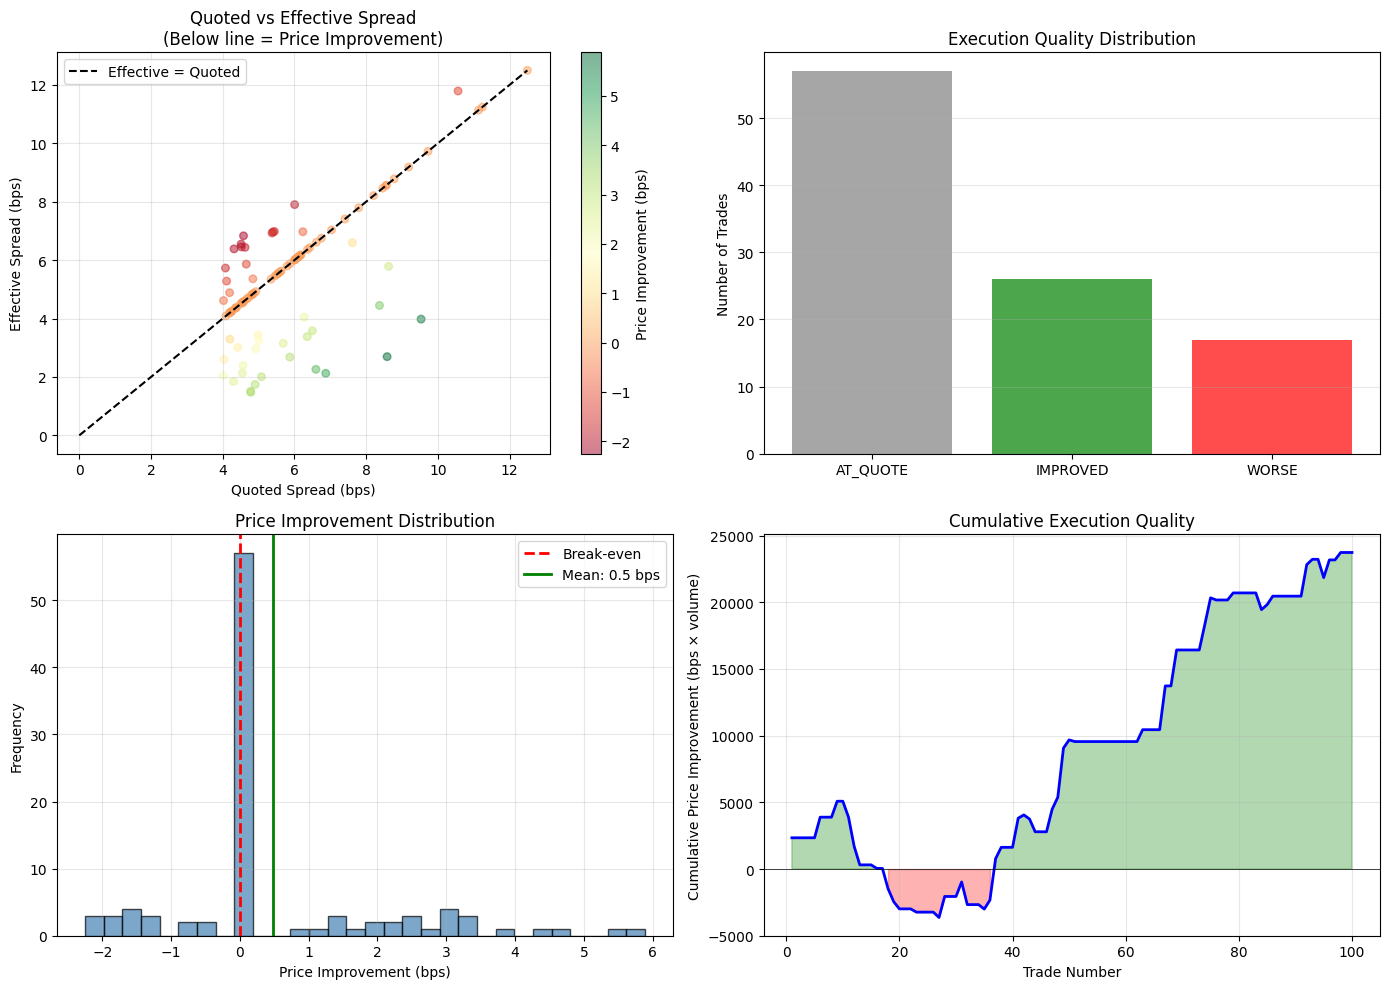

In [11]:
# Question 10: Effective Spread Calculation

def calculate_spreads(trade_price: float, bid: float, ask: float) -> dict:
    """
    Calculate quoted and effective spreads.
    
    Parameters:
    -----------
    trade_price : float - Actual execution price
    bid : float - Best bid at time of trade
    ask : float - Best ask at time of trade
    
    Returns:
    --------
    dict : Various spread measures
    """
    mid = (bid + ask) / 2
    
    # Quoted spread
    quoted_spread = ask - bid
    quoted_spread_pct = (quoted_spread / mid) * 100
    quoted_spread_bps = quoted_spread_pct * 100
    
    # Effective spread (2x because we measure from mid)
    effective_spread = 2 * abs(trade_price - mid)
    effective_spread_pct = (effective_spread / mid) * 100
    effective_spread_bps = effective_spread_pct * 100
    
    # Price improvement (positive = good)
    price_improvement = quoted_spread - effective_spread
    price_improvement_pct = (price_improvement / quoted_spread) * 100 if quoted_spread > 0 else 0
    
    return {
        'bid': bid,
        'ask': ask,
        'mid': mid,
        'trade_price': trade_price,
        'quoted_spread': quoted_spread,
        'quoted_spread_bps': quoted_spread_bps,
        'effective_spread': effective_spread,
        'effective_spread_bps': effective_spread_bps,
        'price_improvement': price_improvement,
        'price_improvement_pct': price_improvement_pct
    }


def analyze_execution_quality(trades_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze execution quality for multiple trades.
    """
    df = trades_df.copy()
    
    # Calculate metrics
    df['mid'] = (df['bid'] + df['ask']) / 2
    df['quoted_spread'] = df['ask'] - df['bid']
    df['effective_spread'] = 2 * np.abs(df['trade_price'] - df['mid'])
    
    # Basis points
    df['quoted_spread_bps'] = (df['quoted_spread'] / df['mid']) * 10000
    df['effective_spread_bps'] = (df['effective_spread'] / df['mid']) * 10000
    
    # Price improvement
    df['price_improvement_bps'] = df['quoted_spread_bps'] - df['effective_spread_bps']
    
    # Classification
    df['execution_quality'] = np.where(
        df['effective_spread_bps'] < df['quoted_spread_bps'] - 0.1, 'IMPROVED',
        np.where(df['effective_spread_bps'] > df['quoted_spread_bps'] + 0.1, 'WORSE', 'AT_QUOTE')
    )
    
    return df


# Example 1: Single trade analysis
print("=" * 70)
print("EFFECTIVE SPREAD CALCULATION - SINGLE TRADE")
print("=" * 70)

# Trade details
bid, ask = 100.00, 100.04  # 4 cent spread
trade_price = 100.01  # Bought below midpoint (price improvement!)

result = calculate_spreads(trade_price, bid, ask)

print("\nTrade Details:")
print(f"  Bid:         ${result['bid']:.2f}")
print(f"  Ask:         ${result['ask']:.2f}")
print(f"  Mid:         ${result['mid']:.2f}")
print(f"  Trade Price: ${result['trade_price']:.2f}")

print("\nSpread Analysis:")
print(f"  Quoted Spread:    ${result['quoted_spread']:.4f} ({result['quoted_spread_bps']:.2f} bps)")
print(f"  Effective Spread: ${result['effective_spread']:.4f} ({result['effective_spread_bps']:.2f} bps)")
print(f"  Price Improvement: ${result['price_improvement']:.4f} ({result['price_improvement_pct']:.1f}%)")

# Example 2: Multiple trades analysis
print("\n" + "=" * 70)
print("EXECUTION QUALITY ANALYSIS - MULTIPLE TRADES")
print("=" * 70)

np.random.seed(42)
n_trades = 100

# Simulate quotes and trades
mid_prices = 100 + np.cumsum(np.random.randn(n_trades) * 0.01)
half_spreads = 0.02 + np.random.exponential(0.01, n_trades)  # Variable spread

bids = mid_prices - half_spreads
asks = mid_prices + half_spreads

# Trade prices: some at bid/ask, some improved, some worse
trade_types = np.random.choice(['at_bid', 'at_ask', 'improved', 'worse'], 
                                n_trades, p=[0.3, 0.3, 0.25, 0.15])
trade_prices = np.zeros(n_trades)

for i in range(n_trades):
    mid = mid_prices[i]
    if trade_types[i] == 'at_bid':
        trade_prices[i] = bids[i]
    elif trade_types[i] == 'at_ask':
        trade_prices[i] = asks[i]
    elif trade_types[i] == 'improved':
        # Trade between mid and bid/ask
        direction = np.random.choice([-1, 1])
        improvement = np.random.uniform(0.3, 0.9) * half_spreads[i]
        trade_prices[i] = mid + direction * improvement
    else:  # worse
        # Trade outside quotes
        direction = np.random.choice([-1, 1])
        slippage = half_spreads[i] * np.random.uniform(1.1, 1.5)
        trade_prices[i] = mid + direction * slippage

trades_df = pd.DataFrame({
    'trade_id': range(1, n_trades + 1),
    'trade_price': trade_prices,
    'bid': bids,
    'ask': asks,
    'volume': np.random.randint(100, 1000, n_trades)
})

# Analyze
analyzed_df = analyze_execution_quality(trades_df)

# Summary statistics
print("\nExecution Quality Summary:")
print("-" * 50)
quality_counts = analyzed_df['execution_quality'].value_counts()
for quality, count in quality_counts.items():
    pct = count / n_trades * 100
    print(f"  {quality:<15}: {count:>4} trades ({pct:>5.1f}%)")

print(f"\nSpread Statistics (basis points):")
print("-" * 50)
print(f"  Average Quoted Spread:    {analyzed_df['quoted_spread_bps'].mean():.2f} bps")
print(f"  Average Effective Spread: {analyzed_df['effective_spread_bps'].mean():.2f} bps")
print(f"  Average Price Improvement:{analyzed_df['price_improvement_bps'].mean():.2f} bps")

# Volume-weighted averages
vw_quoted = (analyzed_df['quoted_spread_bps'] * analyzed_df['volume']).sum() / analyzed_df['volume'].sum()
vw_effective = (analyzed_df['effective_spread_bps'] * analyzed_df['volume']).sum() / analyzed_df['volume'].sum()

print(f"\n  Vol-Weighted Quoted:      {vw_quoted:.2f} bps")
print(f"  Vol-Weighted Effective:   {vw_effective:.2f} bps")

# Cost analysis
total_volume = analyzed_df['volume'].sum()
total_cost_quoted = (analyzed_df['quoted_spread_bps'] / 10000 * analyzed_df['mid'] * analyzed_df['volume']).sum()
total_cost_effective = (analyzed_df['effective_spread_bps'] / 10000 * analyzed_df['mid'] * analyzed_df['volume']).sum()

print(f"\nTransaction Cost Analysis:")
print("-" * 50)
print(f"  Total Volume: {total_volume:,} shares")
print(f"  Cost at Quoted Spread:    ${total_cost_quoted:,.2f}")
print(f"  Actual Cost (Effective):  ${total_cost_effective:,.2f}")
print(f"  Savings from Improvement: ${total_cost_quoted - total_cost_effective:,.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Quoted vs Effective spread scatter
axes[0, 0].scatter(analyzed_df['quoted_spread_bps'], analyzed_df['effective_spread_bps'],
                   alpha=0.5, c=analyzed_df['price_improvement_bps'], cmap='RdYlGn', s=30)
max_spread = max(analyzed_df['quoted_spread_bps'].max(), analyzed_df['effective_spread_bps'].max())
axes[0, 0].plot([0, max_spread], [0, max_spread], 'k--', label='Effective = Quoted')
axes[0, 0].set_xlabel('Quoted Spread (bps)')
axes[0, 0].set_ylabel('Effective Spread (bps)')
axes[0, 0].set_title('Quoted vs Effective Spread\n(Below line = Price Improvement)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0], label='Price Improvement (bps)')

# Execution quality distribution
colors_bar = {'IMPROVED': 'green', 'AT_QUOTE': 'gray', 'WORSE': 'red'}
quality_colors = [colors_bar[q] for q in quality_counts.index]
axes[0, 1].bar(quality_counts.index, quality_counts.values, color=quality_colors, alpha=0.7)
axes[0, 1].set_ylabel('Number of Trades')
axes[0, 1].set_title('Execution Quality Distribution')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Price improvement histogram
axes[1, 0].hist(analyzed_df['price_improvement_bps'], bins=30, alpha=0.7, 
                color='steelblue', edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
axes[1, 0].axvline(x=analyzed_df['price_improvement_bps'].mean(), color='green', 
                    linestyle='-', linewidth=2, label=f"Mean: {analyzed_df['price_improvement_bps'].mean():.1f} bps")
axes[1, 0].set_xlabel('Price Improvement (bps)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Price Improvement Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative improvement over time
cumulative_improvement = (analyzed_df['price_improvement_bps'] * analyzed_df['volume']).cumsum()
axes[1, 1].plot(analyzed_df['trade_id'], cumulative_improvement, 'b-', linewidth=2)
axes[1, 1].fill_between(analyzed_df['trade_id'], 0, cumulative_improvement,
                         where=cumulative_improvement > 0, alpha=0.3, color='green')
axes[1, 1].fill_between(analyzed_df['trade_id'], 0, cumulative_improvement,
                         where=cumulative_improvement < 0, alpha=0.3, color='red')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].set_xlabel('Trade Number')
axes[1, 1].set_ylabel('Cumulative Price Improvement (bps × volume)')
axes[1, 1].set_title('Cumulative Execution Quality')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()